# Energy Resolution of Germanium detectors

Eugenia Boccanera 2109310  
Lucrezia Rossi 2122164

NaI and Germanium detectors have wide fields of application for γ- and X-ray spectrometry thanks to their good energy resolution. The energy resolution of these detectors is defined as the width of the detected energy spectra peaks (FWHM); it depends on  
    - the statistics of the charge creation process  
    - the properties of the detector, and primarly its charge collelction efficency   
    - the electronics noise  

The resolution can be expressed as the squared sum of two terms:   
$$FWHM = \sqrt{(w_d)^2 + (w_e)^2}$$   
where the first term depends on the detector properties as:  
$w_d = 2 · \sqrt{(2 · \log(2)) · F · E_{\gamma} ·  w}$   
with $F$ the _Fano factor_,  
$E_{\gamma}$  the energy of the photon deposited energy  
$w$ the electron hole-produced energy threshold in germanium (w ~ 3eV).

The $w_e$ term in eq.1 is connected with the readout electronics and depends on the detector capacitance, the size of the detector and the bias voltage.


## Step 1. Data Inspection and FWHM derivation

In [59]:
# Functions
# Function to plot the spectrum
plot_spectrum <- function(data, title) {
  ggplot(data, aes(x = Channel, y = log_Count)) +
    geom_line(col='black', lwd=0.2, na.rm = TRUE) +
    ggtitle(title) +
    xlab("Channel") +
    ylab("log(Counts)") +
    theme_minimal() +
    theme(axis.title = element_text(size = 14))
}

#Function to find indices of values closest to specified x values
find_indices_around_x <- function(data, x_values, window_size = 10) {
  indices <- numeric(0)
  for (x_val in x_values) {
    # Find the index closest to x_val
    closest_index <- which.min(abs(data$Channel - x_val))
    
    # Define the data window around closest_index
    start_index <- max(1, closest_index - window_size)
    end_index <- min(nrow(data), closest_index + window_size)
    
    window_data <- data[start_index:end_index, ]
    
    # Find the index of the maximum value of log_Count within the window
    max_log_count_index <- which.max(window_data$log_Count)
    
    # Adjust the index relative to the window to the global index
    actual_index <- start_index + max_log_count_index - 1
    
    indices <- c(indices, actual_index)
  }
  return(indices)
}

# Function to smooth data
smooth_data <- function(data, window_size) {
  smoothed_values <- movavg(data$log_Count, n = window_size, type = "s")
  smoothed_data <- data
  smoothed_data$log_Count <- smoothed_values
  return(smoothed_data)
}

#  Function to plot the peaks 
plot_peaks_around_x <- function(data, title, x_values, window_size, apply_smoothing = TRUE) {
  if (apply_smoothing) {
    data <- smooth_data(data, window_size)
  }
  indices <- find_indices_around_x(data, x_values)
  
  # Plot the data with red points at specified x values
  ggplot(data, aes(x = Channel, y = log_Count)) +
    geom_line() +
    geom_point(data = data[indices, ], aes(x = Channel, y = log_Count), color = "red", size = 2) +
    ggtitle(title) +
    xlab("Channel") +
    ylab("Log(Counts)") +
    theme_minimal() +
    theme(plot.title = element_text(size = 20),
          axis.title = element_text(size = 15),
          axis.text = element_text(size = 12))
}

# Function to find the position of the peaks
find_and_return_peaks_around_x <- function(data, x_values, window_size, apply_smoothing = TRUE) {
  if (apply_smoothing) {
    data <- smooth_data(data, window_size)
  }
  indices <- find_indices_around_x(data, x_values)
  # Get peak position
  peak_positions <- data$Channel[indices]
  # Return peak positions
  return(peak_positions)
}

# Function to extract data points around each peak
extract_peak_data <- function(data, peak_positions, window_size) {
  peak_data_list <- list()
  for (peak_pos in peak_positions) {
    # Find the closest index to the peak position
    index <- which.min(abs(data$Channel - peak_pos))
    
    # Extract data within the window size around the peak position
    start_index <- max(1, index - window_size)
    end_index <- min(nrow(data), index + window_size)
    
    # Subset the data
    peak_data <- data[start_index:end_index, ]
    # Store the subsetted data in a list with peak position as key
    peak_data_list[[as.character(peak_pos)]] <- peak_data
  }
  
  return(peak_data_list)
}

# Function to fit Gaussian model using nls
fit_gaussian_nls <- function(peak_data) {
  # Initial guesses for the parameters
  mu_init <- peak_data$Channel[which.max(peak_data$log_Count)]
  sigma_init <- diff(range(peak_data$Channel)) / 4  # Quarter of the range
  A_init <- max(peak_data$log_Count)
  
  # Define the Gaussian function
  gaussian <- function(x, mu, sigma, A) {
    A * exp(-0.5 * ((x - mu) / sigma)^2)
  }
  
  # Fit the model using nls
  fit <- nls(log_Count ~ gaussian(Channel, mu, sigma, A), data = peak_data,
             start = list(mu = mu_init, sigma = sigma_init, A = A_init),
             control = nls.control(maxiter = 100))
  return(fit)
}

# Function to calculate FWHM from fitted Gaussian parameters
calculate_fwhm <- function(fit) {
  coef_fit <- coef(fit)  # extract the coefficients
  sigma <- coef_fit["sigma"]
  FWHM <- 2 * sqrt(2 * log(2)) * sigma
  return(FWHM)
}

### 1.a Load the required libraries

In [60]:
# Load the libraries
library(rjags)
library(ggplot2)
library(bayesplot)

library(dplyr)
library(nlstools)
library(pracma)

library(gridExtra)


### 1.b Load the data

The data in the files represent a typical energy spectrum obtained from a detector, in this case, a germanium detector, after being irradiated by a source containing a specific element. Each row of the file contains two values:

The first value represents the detector channel, which is essentially the index or position of the data in the file.
The second value represents the number of counts (or events) recorded in that channel during the energy measurement.

**Detector Channel:**

Every energy detector (such as a germanium detector) divides the range of energy it can measure into discrete channels. Each channel corresponds to a specific energy range that the detector can detect.

**Counts:**

The recorded counts represent the number of times the detector has detected an energy event (a gamma photon, in the case of a germanium detector) in that particular channel during the experimen



In [61]:
# Load the data
gr11_co60 <- read.table("gr11_co60.txt", header = FALSE)
gr11_cs137 <- read.table("gr11_cs137.txt", header = FALSE)
gr11_na22 <- read.table("gr11_na22.txt", header = FALSE)
IC48A_AmCsCo <- read.table("IC48A_AmCsCo.txt", header = FALSE)
IC48A_Th <- read.table("IC48A_Th.txt", header = FALSE)

# Assign column names
colnames(gr11_co60) <- c("Channel", "Count")
colnames(gr11_cs137) <- c("Channel", "Count")
colnames(gr11_na22) <- c("Channel", "Count")
colnames(IC48A_AmCsCo) <- c("Channel", "Count")
colnames(IC48A_Th) <- c("Channel", "Count")

# Drop the rows with Count < 0
gr11_co60 <- gr11_co60[gr11_co60$Count >= 0, ]
gr11_cs137 <- gr11_cs137[gr11_cs137$Count >= 0, ]
gr11_na22 <- gr11_na22[gr11_na22$Count >= 0, ]
IC48A_AmCsCo <- IC48A_AmCsCo[IC48A_AmCsCo$Count >= 0, ]
IC48A_Th <- IC48A_Th[IC48A_Th$Count >= 0, ]

# Add the column log_Count
gr11_co60$log_Count <- log(gr11_co60$Count + 1)
gr11_cs137$log_Count <- log(gr11_cs137$Count + 1)
gr11_na22$log_Count <- log(gr11_na22$Count + 1)
IC48A_AmCsCo$log_Count <- log(IC48A_AmCsCo$Count + 1)
IC48A_Th$log_Count <- log(IC48A_Th$Count + 1)


### 1.c Inspect the Data - Plot the Spectra

Each peak in the spectrum represents a specific energy of the gamma photons emitted by radioactive sources such as Co-60, Cs-137, Na-22, AmCsCo, or Th. Analyzing these spectra allows for the identification and characterization of the radioactive sources present, evaluation of the detector's energy resolution, and the study of other properties of the detector and the sources.

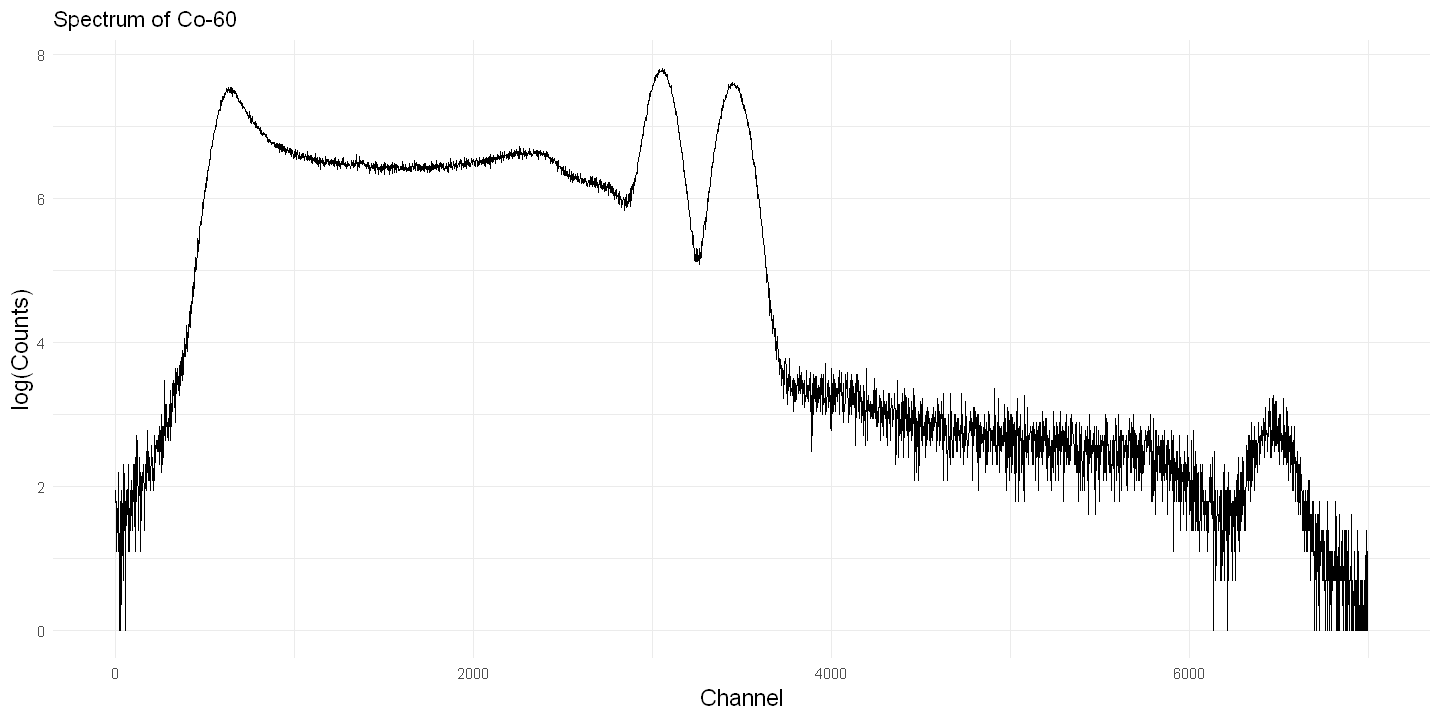

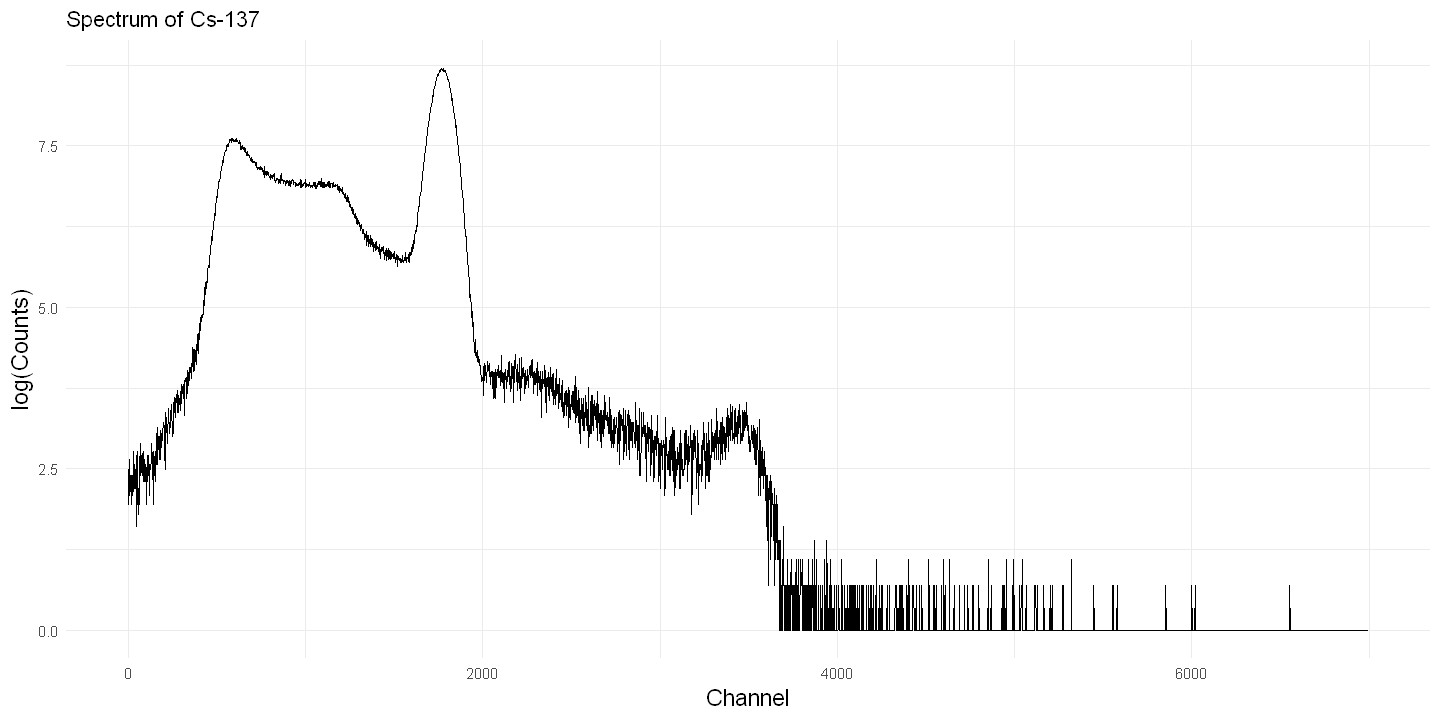

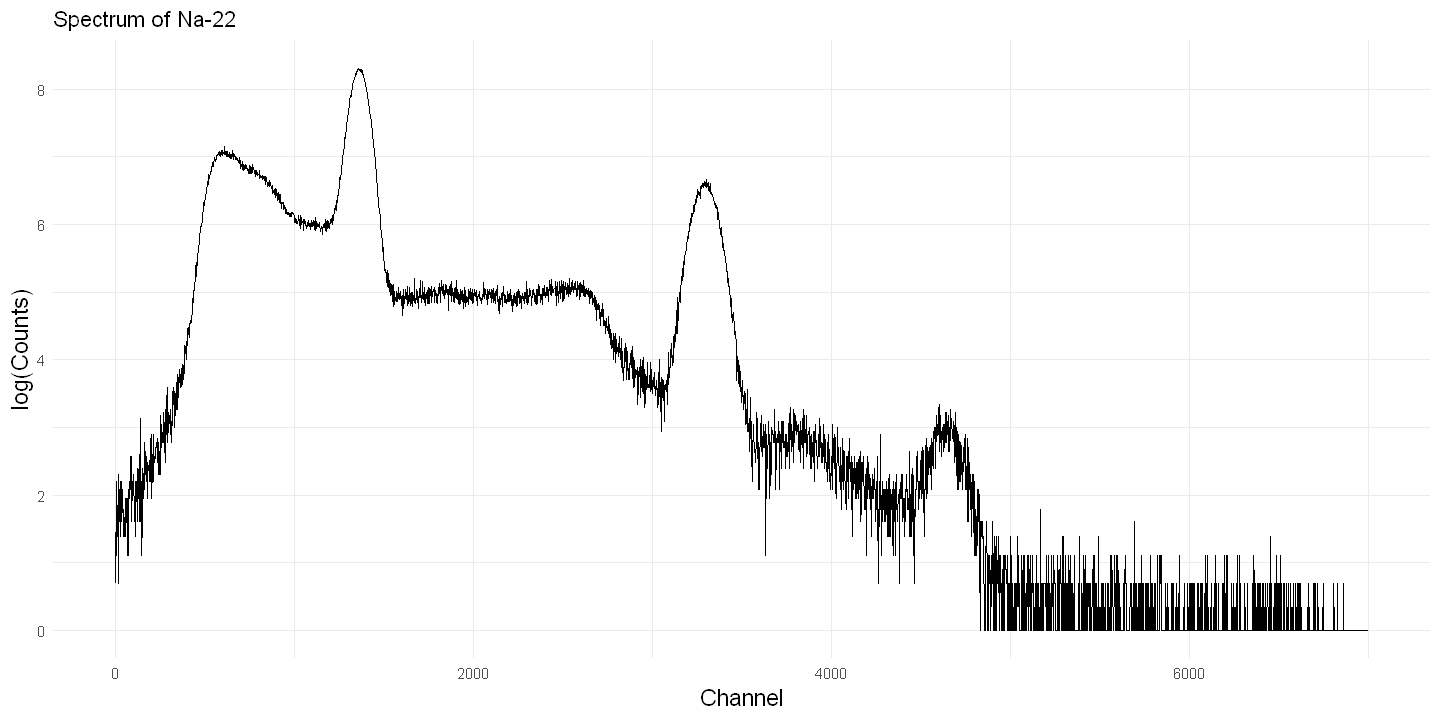

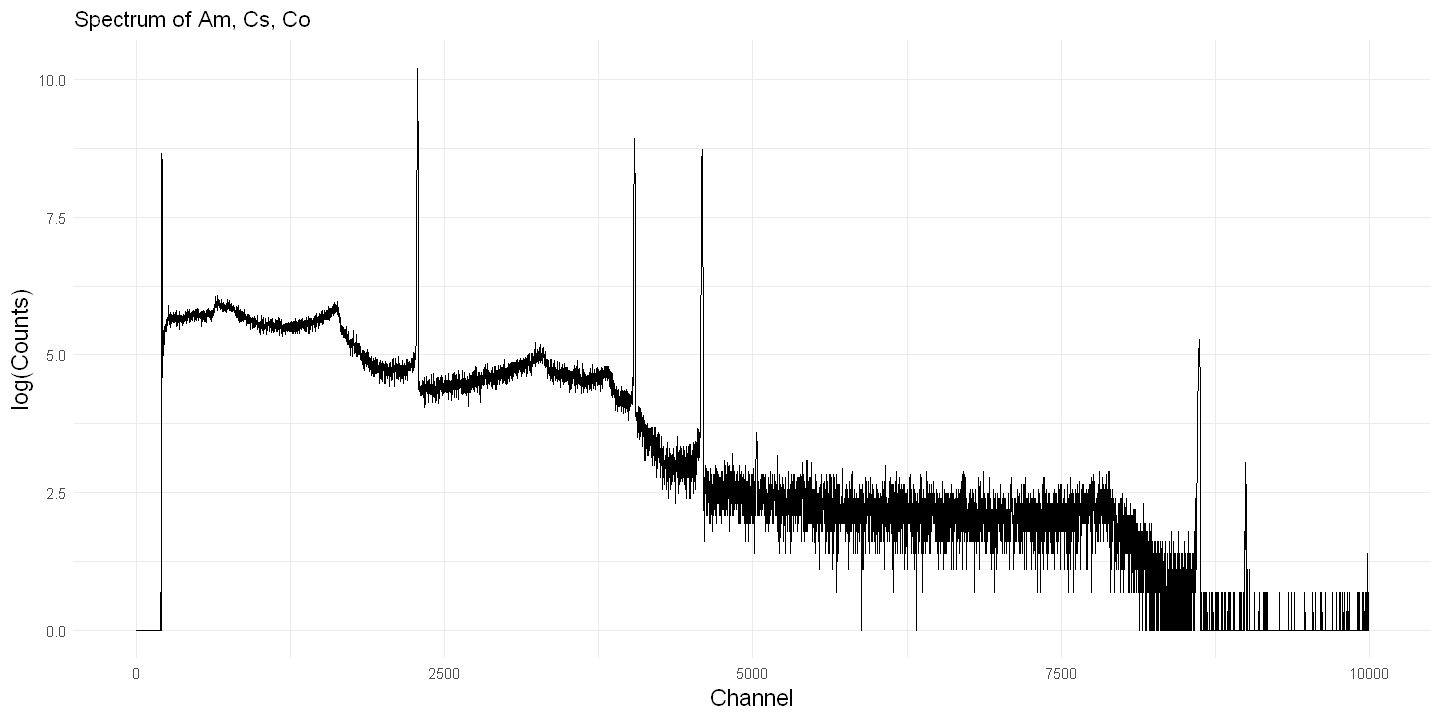

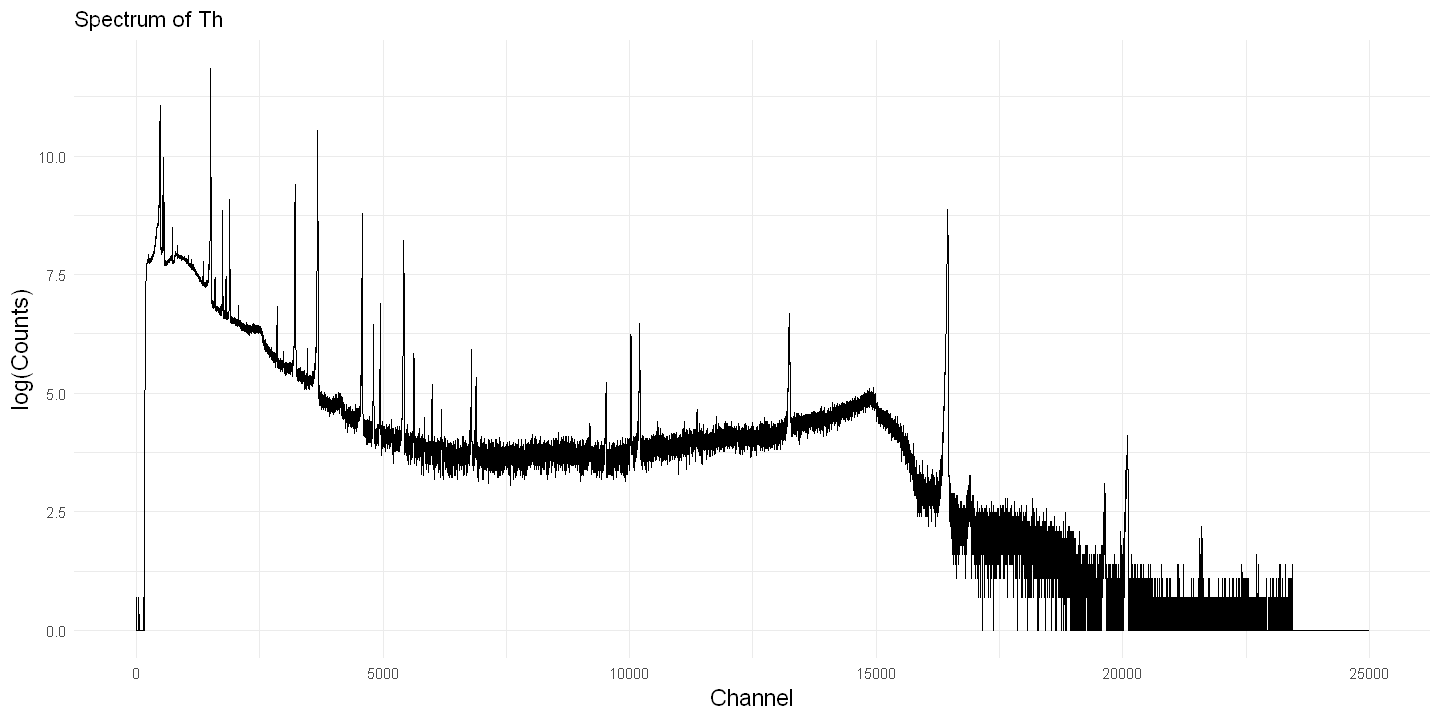

In [62]:
# Plot function
options(repr.plot.width = 12, repr.plot.height = 6)

# Plot each spectrum
plot_spectrum(gr11_co60, "Spectrum of Co-60")
plot_spectrum(gr11_cs137, "Spectrum of Cs-137")
plot_spectrum(gr11_na22, "Spectrum of Na-22")
plot_spectrum(IC48A_AmCsCo, "Spectrum of Am, Cs, Co")
plot_spectrum(IC48A_Th, "Spectrum of Th")


### 1.d Find Peaks  and Infer FWHM

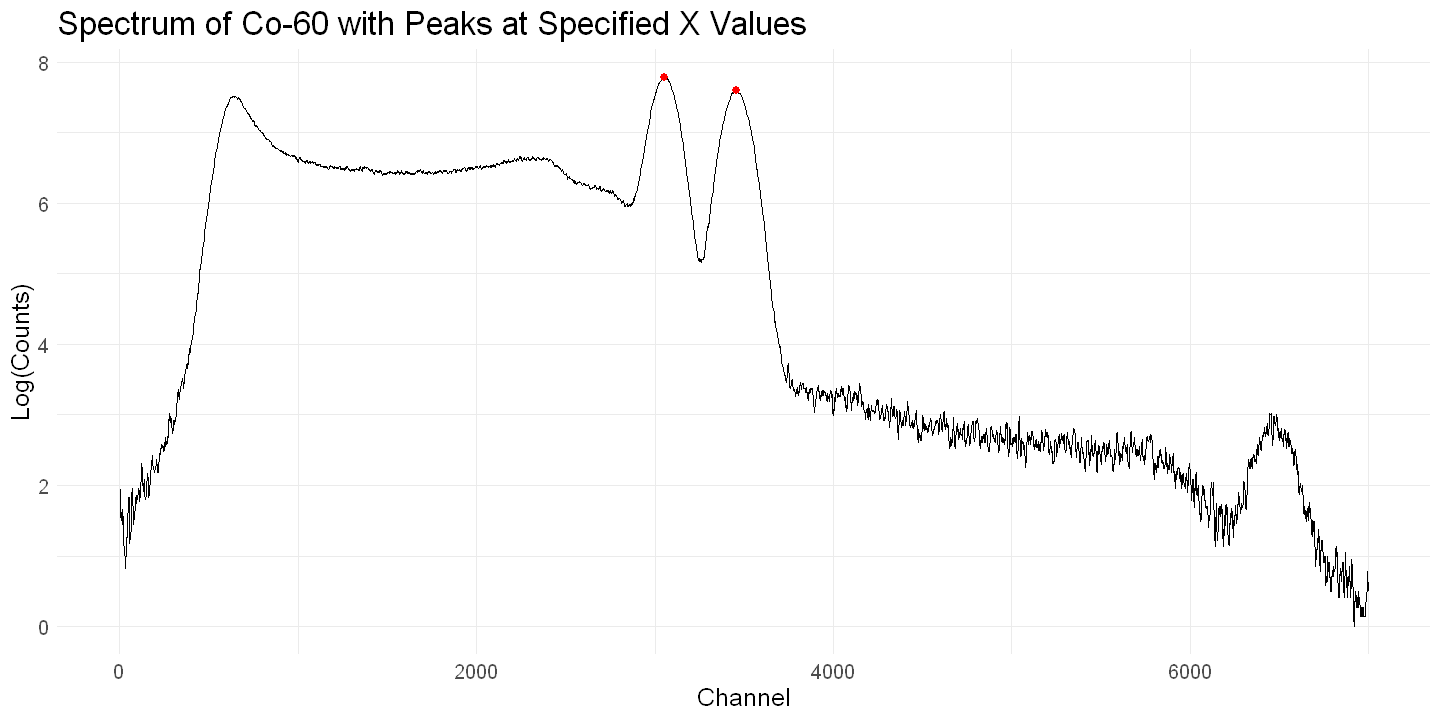

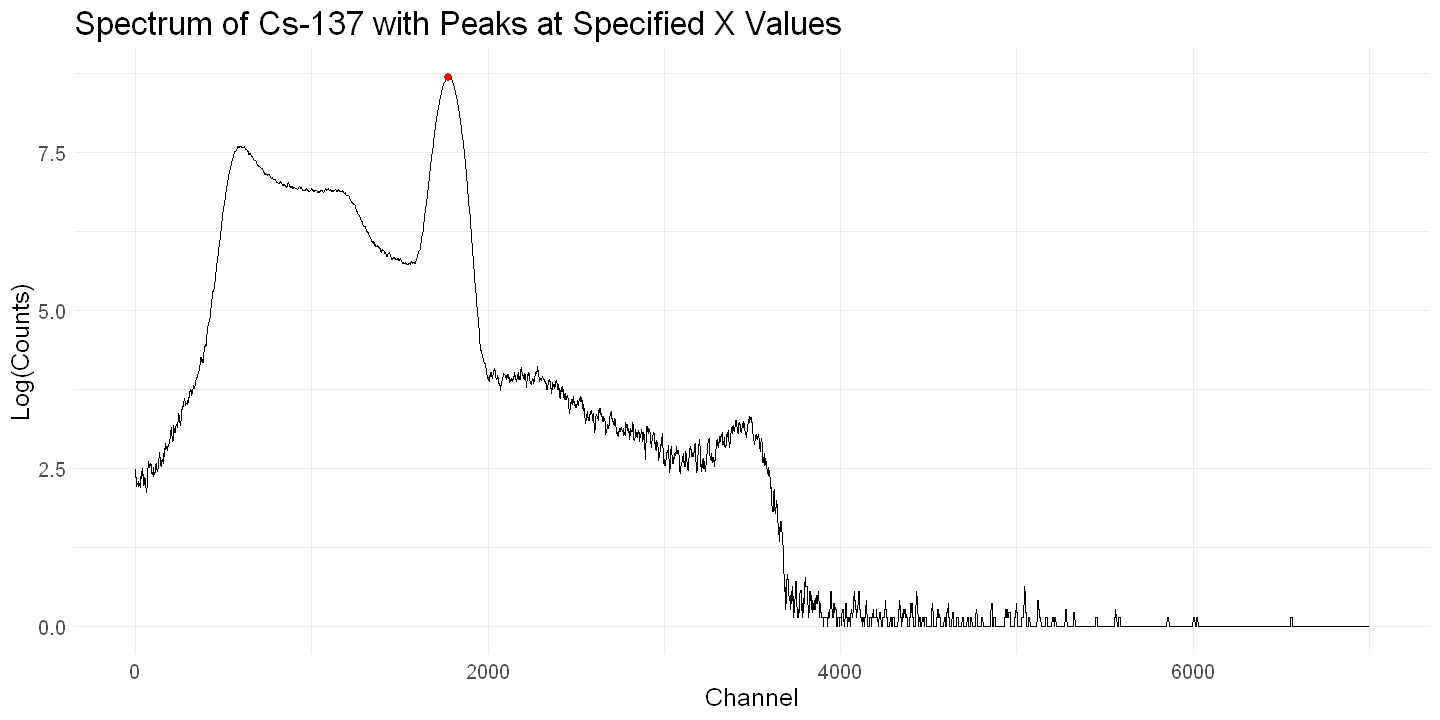

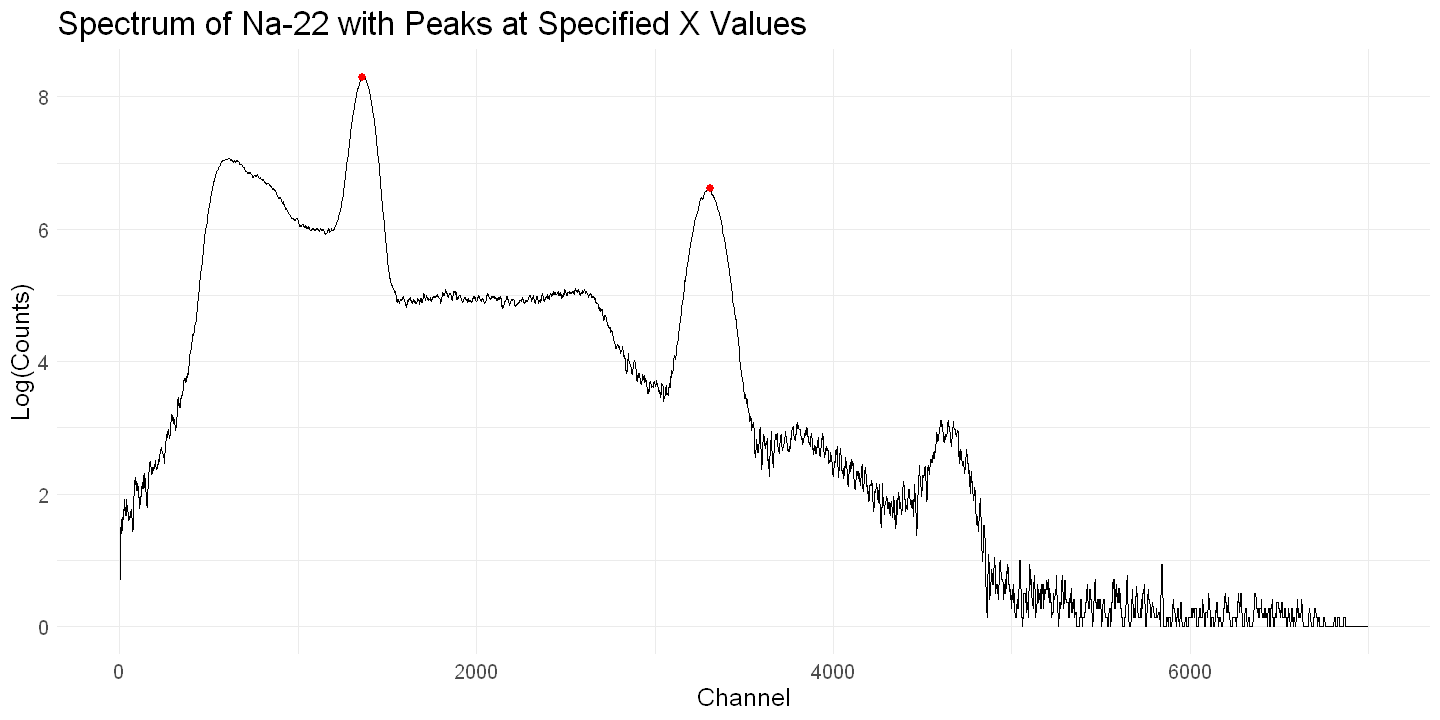

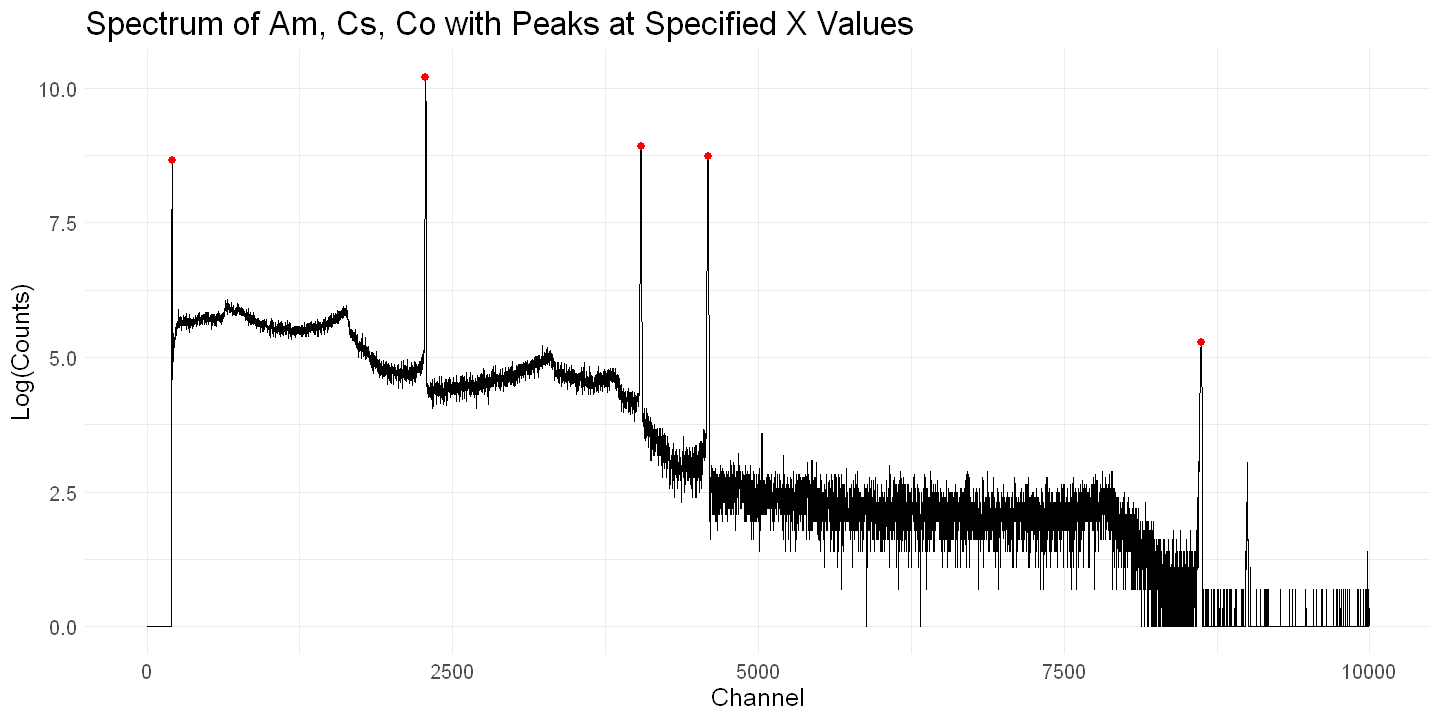

[1] 3053 3455

[1] 1773

[1] 1361 3311

[1]  206 2279 4040 4588 8622

[1]   485  1503  1890  3217  3673  4580  4946  5419  6792  9524 10027 10204
[13] 13238 16449 20096

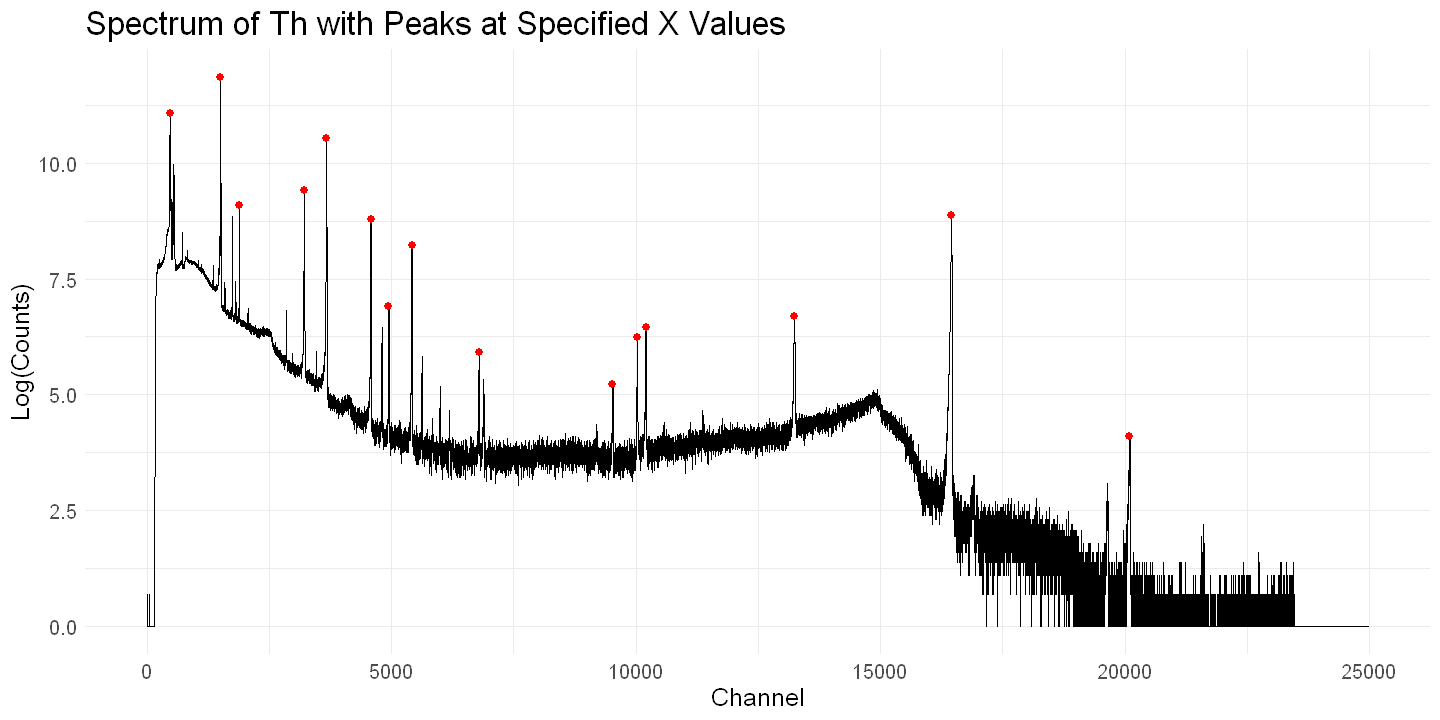

In [63]:
# Inferred initial positions of the peaks
position_co60 <- c(3058, 3458)
position_cs137 <- c(1779)
position_na22 <- c( 1366, 3302)
position_AmCsCo<- c(206, 2280, 4041, 4589, 8623) 
position_Th <- c( 485, 1504,1890,  3218, 3674, 4581,4948 , 5420, 6793, 9525, 10025, 10202,13240, 16452, 20099) 


# Plot the peak positions
plot_peaks_around_x(gr11_co60, "Spectrum of Co-60 with Peaks at Specified X Values", x_values =position_co60, window_size = 5, apply_smoothing = TRUE)
plot_peaks_around_x(gr11_cs137, "Spectrum of Cs-137 with Peaks at Specified X Values", x_values = position_cs137, window_size = 5, apply_smoothing = TRUE)
plot_peaks_around_x(gr11_na22, "Spectrum of Na-22 with Peaks at Specified X Values", x_values = position_na22, window_size = 5, apply_smoothing = TRUE)
plot_peaks_around_x(IC48A_AmCsCo, "Spectrum of Am, Cs, Co with Peaks at Specified X Values", x_values = position_AmCsCo, window_size = 8, apply_smoothing = FALSE)
plot_peaks_around_x(IC48A_Th, "Spectrum of Th with Peaks at Specified X Values", x_values = position_Th, window_size = 8, apply_smoothing = FALSE)

# Return the peak positions
peaks_co60 <- find_and_return_peaks_around_x (gr11_co60, x_values = position_co60, window_size = 5, apply_smoothing = TRUE)
peaks_cs137 <- find_and_return_peaks_around_x (gr11_cs137, x_values = position_cs137, window_size = 5, apply_smoothing = TRUE)
peaks_na22 <- find_and_return_peaks_around_x (gr11_na22, x_values = position_na22, window_size = 5, apply_smoothing = TRUE)
peaks_AmCsCo <- find_and_return_peaks_around_x (IC48A_AmCsCo, x_values = position_AmCsCo, window_size = 8, apply_smoothing = FALSE)
peaks_Th <- find_and_return_peaks_around_x (IC48A_Th, x_values = position_Th, window_size = 8, apply_smoothing = FALSE)

peaks_co60
peaks_cs137
peaks_na22
peaks_AmCsCo
peaks_Th

In [64]:
# Extract data points around each peak
peak_data_list_AmCsCo <- extract_peak_data(IC48A_AmCsCo, peaks_AmCsCo, window_size = 13)
peak_data_list_Th <- extract_peak_data(IC48A_Th, peaks_Th, window_size = 9)

### 1.e Fit Gaussian and Calculate FWHM 

Now we fit a Gaussian model to peak data using initial parameter guesses and non-linear least squares optimization. Then we apply this fitting procedure to the sets of peak data and outputs the results.

In [94]:
# Fit the model for each peak
fits_AmCsCo <- lapply(peak_data_list_AmCsCo, fit_gaussian_nls)
fits_Th <- lapply(peak_data_list_Th, fit_gaussian_nls)

cat('Fits_AmCsCo: \n')
fits_AmCsCo
#cat('Fits_Th: \n')
#fits_Th


Fits_AmCsCo: 


$`206`
Nonlinear regression model
  model: log_Count ~ gaussian(Channel, mu, sigma, A)
   data: peak_data
     mu   sigma       A 
209.717   6.894   7.135 
 residual sum-of-squares: 67.93

Number of iterations to convergence: 14 
Achieved convergence tolerance: 6.629e-06

$`2279`
Nonlinear regression model
  model: log_Count ~ gaussian(Channel, mu, sigma, A)
   data: peak_data
      mu    sigma        A 
2278.595    8.982    9.609 
 residual sum-of-squares: 14.74

Number of iterations to convergence: 7 
Achieved convergence tolerance: 1.795e-06

$`4040`
Nonlinear regression model
  model: log_Count ~ gaussian(Channel, mu, sigma, A)
   data: peak_data
      mu    sigma        A 
4039.054    9.601    8.855 
 residual sum-of-squares: 3.02

Number of iterations to convergence: 5 
Achieved convergence tolerance: 3.525e-06

$`4588`
Nonlinear regression model
  model: log_Count ~ gaussian(Channel, mu, sigma, A)
   data: peak_data
      mu    sigma        A 
4586.700    9.258    8.882 
 residu

In [66]:
# Calculate FWHM for each peak
fwhm_values_AmCsCo <- sapply(fits_AmCsCo, calculate_fwhm)
cat('FWHM values for AmCsCo: \n')
print(fwhm_values_AmCsCo)

fwhm_values_Th <- sapply(fits_Th, calculate_fwhm)
cat('FWHM values for Th: \n')
print(fwhm_values_Th)


FWHM values for AmCsCo: 
 206.sigma 2279.sigma 4040.sigma 4588.sigma 8622.sigma 
  16.23476   21.15073   22.60837   21.80166   25.08525 
FWHM values for Th: 
  485.sigma  1503.sigma  1890.sigma  3217.sigma  3673.sigma  4580.sigma 
   27.95363    23.81181    26.31983    28.37143    26.87740    27.52722 
 4946.sigma  5419.sigma  6792.sigma  9524.sigma 10027.sigma 10204.sigma 
   27.06112    28.05850    29.45482    35.76894    32.60921    33.89028 
13238.sigma 16449.sigma 20096.sigma 
   56.11266    51.53291    42.31431 


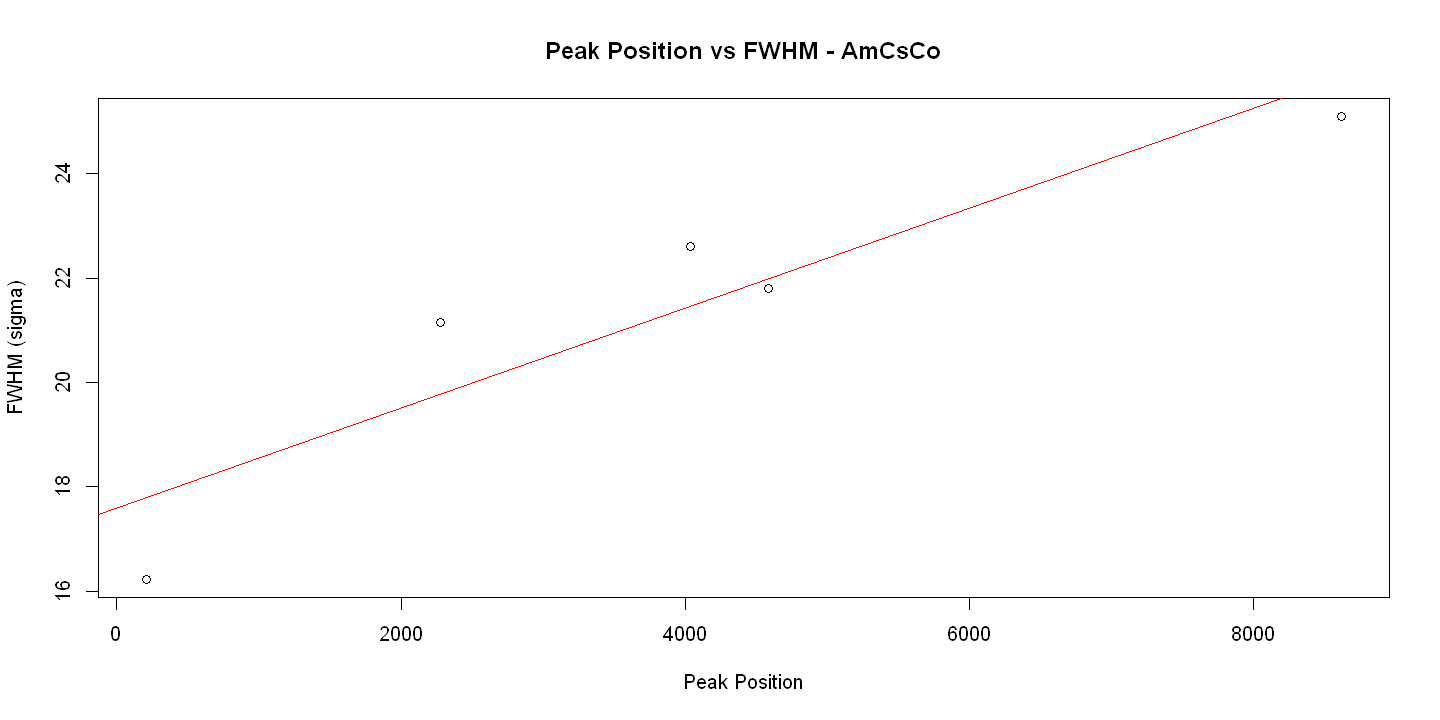

In [67]:
# Let's check the data
peak_positions <- peaks_AmCsCo
fwhm_values <- fwhm_values_AmCsCo

# Plotting peak positions against FWHM values
plot(peak_positions, fwhm_values,
     xlab = "Peak Position",
     ylab = "FWHM (sigma)",
     main = "Peak Position vs FWHM - AmCsCo")

# Adding a linear regression line
abline(lm(fwhm_values ~ peak_positions), col = "red")

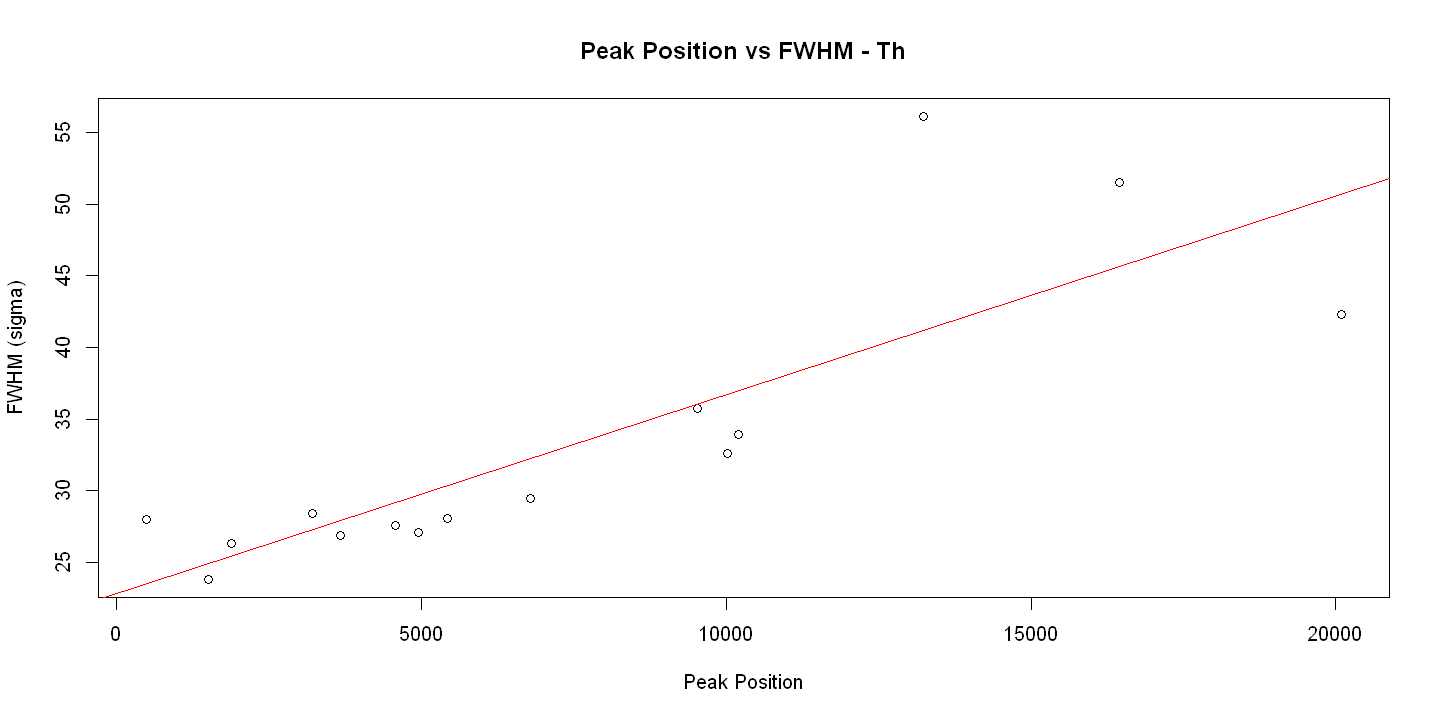

In [68]:
peak_positions <- peaks_Th
fwhm_values <- fwhm_values_Th

# Plotting peak positions against FWHM values
plot(peak_positions, fwhm_values,
     xlab = "Peak Position",
     ylab = "FWHM (sigma)",
     main = "Peak Position vs FWHM - Th")

# Adding a linear regression line
abline(lm(fwhm_values ~ peak_positions), col = "red")

## Step 2: Calibration of Detector
To perform a calibration of the detector, we need to establish a relationship between the channel number (position of the peak) and the known energies of the gamma peaks. Assuming a linear response, this relationship can be expressed as:
$$ E=a⋅x+b $$

where:
* E is the energy in keV,
* x is the channel number,
* a and b are the calibration constants.
We can perform this calibration using a set of known gamma energies corresponding to the detected peaks.


 


In [69]:
# Functions 
# Function to convert channel to energy
channel_to_energy <- function(channel, model, predictor) {
  predict(model, newdata = setNames(data.frame(channel), predictor))
}

#### Steps to Perform Calibration
### 2.a Identify Known Gamma Energies: 
We need to have the nominal gamma peak energies for the isotopes in the data. 

In [70]:
# Given gamma energies (in keV) corresponding to the detected peaks
AmCsCo_energies <- c(59.5409, 661.657, 1173.228, 1332.492, 2505.69)
Th_energies <- c(238.632, 300.089, 510.74, 583.187, 727.330, 763.45 , 785.37, 860.53, 893.408, 1078.63, 1512.70, 1592.511, 1620.738, 2103.511, 2614.511)

# Create a data frame with the positions and corresponding energies
calibration_data_AmCsCo <- data.frame(
  Channel_AmCsCo = peaks_AmCsCo,
  Energy_AmCsCo = AmCsCo_energies
)
calibration_data_Th <- data.frame(
  Channel_Th = peaks_Th,
  Energy_Th = Th_energies
)

### 2.b Fit the Line: 
Use the identified peak positions (centroids) and their corresponding gamma energies to fit a linear model.


Call:
lm(formula = Energy_AmCsCo ~ Channel_AmCsCo, data = calibration_data_AmCsCo)

Residuals:
       1        2        3        4        5 
 0.37492 -0.04524 -0.32487 -0.34205  0.33724 

Coefficients:
                 Estimate Std. Error  t value Pr(>|t|)    
(Intercept)    -7.098e-01  3.092e-01   -2.296    0.105    
Channel_AmCsCo  2.907e-01  6.393e-05 4546.249 2.35e-11 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.3995 on 3 degrees of freedom
Multiple R-squared:      1,	Adjusted R-squared:      1 
F-statistic: 2.067e+07 on 1 and 3 DF,  p-value: 2.347e-11



Call:
lm(formula = Energy_Th ~ Channel_Th, data = calibration_data_Th)

Residuals:
     Min       1Q   Median       3Q      Max 
-240.245  -53.663    0.963   72.249  194.248 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2.070e+02  4.966e+01   4.168   0.0011 ** 
Channel_Th  1.167e-01  5.343e-03  21.850 1.24e-11 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 114.5 on 13 degrees of freedom
Multiple R-squared:  0.9735,	Adjusted R-squared:  0.9715 
F-statistic: 477.4 on 1 and 13 DF,  p-value: 1.241e-11


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


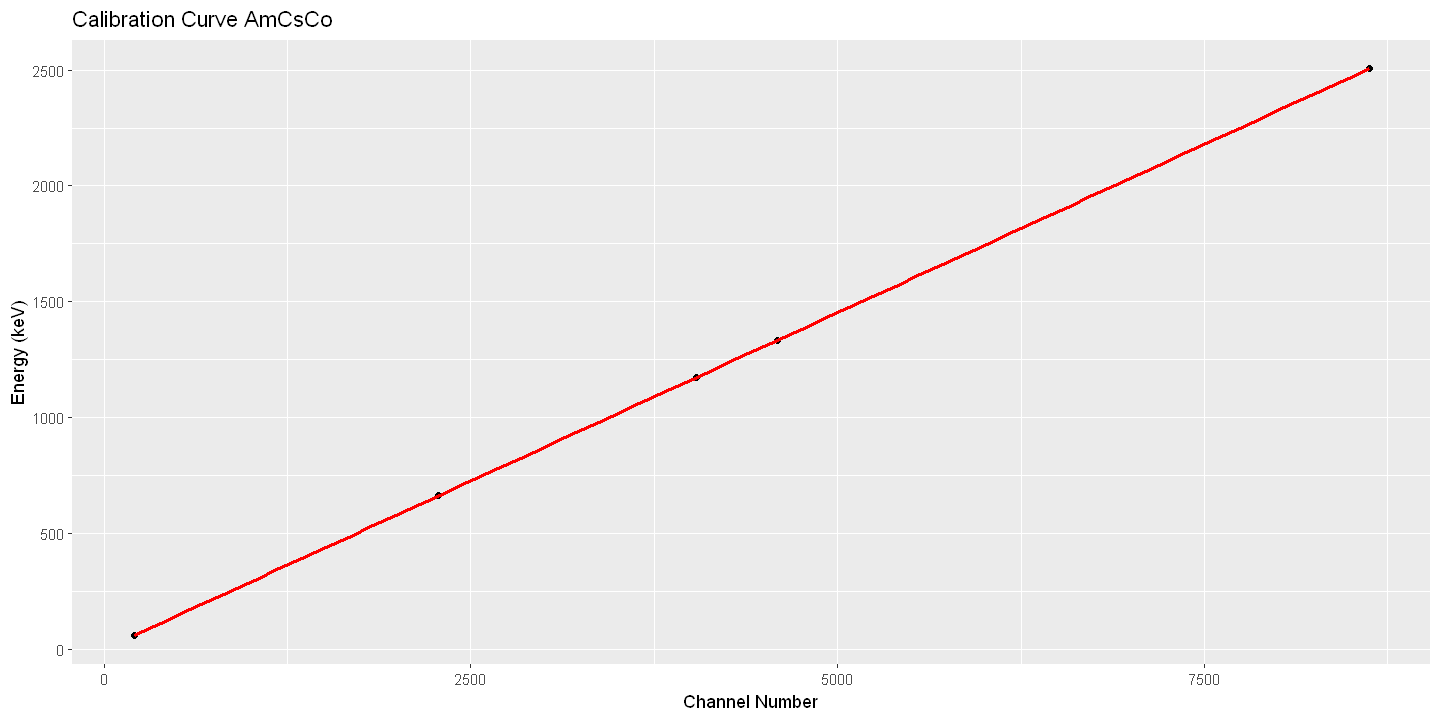

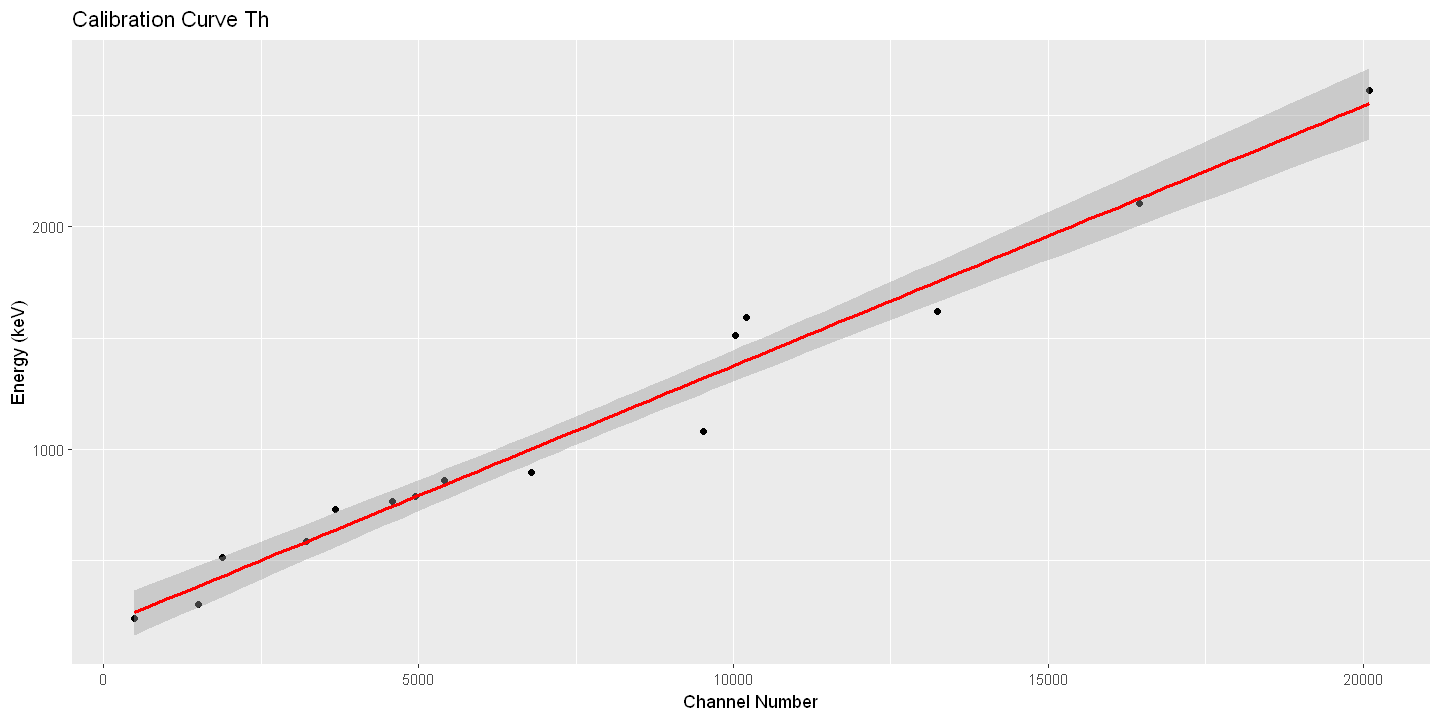

In [71]:
# Fit the linear model
calibration_model_AmCsCo <- lm(Energy_AmCsCo ~ Channel_AmCsCo, data = calibration_data_AmCsCo)
calibration_model_Th <- lm(Energy_Th ~ Channel_Th, data = calibration_data_Th)
summary(calibration_model_AmCsCo)
summary(calibration_model_Th)

# Plot the calibration data and the fitted model
ggplot(calibration_data_AmCsCo, aes(x = Channel_AmCsCo, y = Energy_AmCsCo)) +
  geom_point() +
  geom_smooth(method = "lm", col = "red") +
  ggtitle("Calibration Curve AmCsCo") +
  xlab("Channel Number") +
  ylab("Energy (keV)")

ggplot(calibration_data_Th, aes(x = Channel_Th, y = Energy_Th)) +
  geom_point() +
  geom_smooth(method = "lm", col = "red") +
  ggtitle("Calibration Curve Th") +
  xlab("Channel Number") +
  ylab("Energy (keV)")

### 2.c Apply Calibration: Use the linear model to convert channel numbers to energies.  

  Channel_AmCsCo Energy_AmCsCo
1            206      59.16598
2           2279     661.70224
3           4040    1173.55287
4           4588    1332.83405
5           8622    2505.35276

   Channel_Th Energy_Th
1         485  263.5988
2        1503  382.4473
3        1890  427.6284
4        3217  582.5517
5        3673  635.7884
6        4580  741.6780
7        4946  784.4074
8        5419  839.6287
9        6792  999.9224
10       9524 1318.8754
11      10027 1377.5992
12      10204 1398.2634
13      13238 1752.4740
14      16449 2127.3488
15      20096 2553.1253


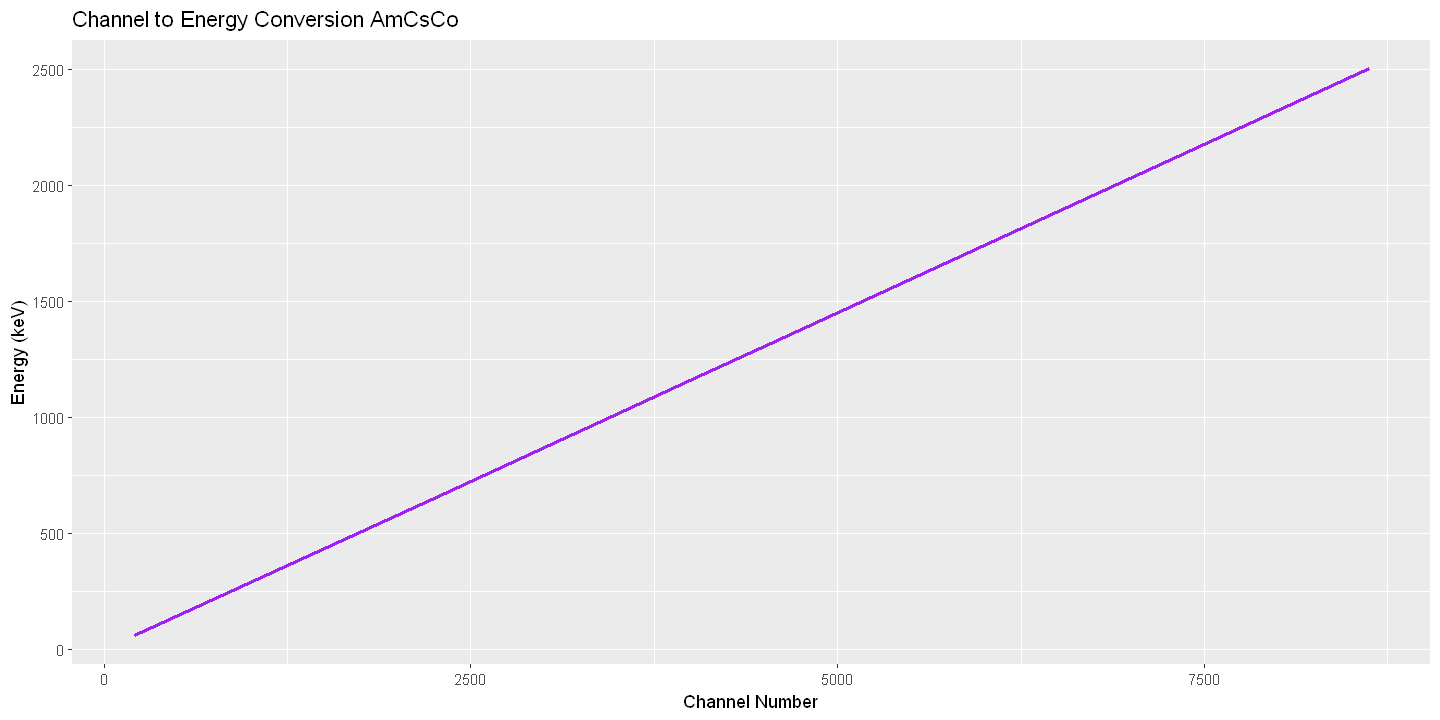

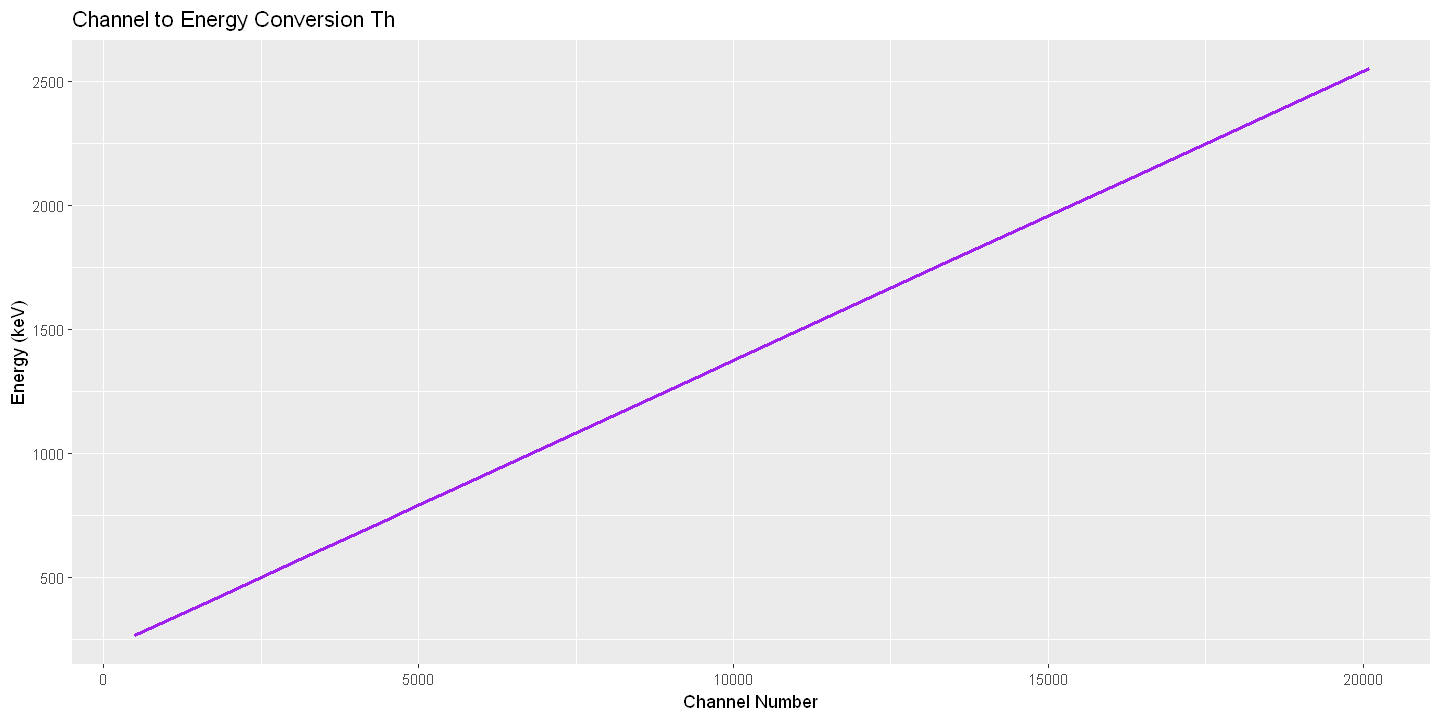

In [72]:
# Apply calibration to the channels
energies_AmCsCo <- channel_to_energy(calibration_data_AmCsCo$Channel_AmCsCo, calibration_model_AmCsCo, "Channel_AmCsCo")
energies_Th <- channel_to_energy(calibration_data_Th$Channel_Th, calibration_model_Th, "Channel_Th")

# Create a data frame with channels and corresponding energies
calibrated_data_AmCsCo <- data.frame(Channel_AmCsCo = calibration_data_AmCsCo$Channel_AmCsCo,
                              Energy_AmCsCo = energies_AmCsCo)
calibrated_data_Th <- data.frame(Channel_Th = calibration_data_Th$Channel_Th,
                              Energy_Th = energies_Th)

# Print the calibrated data
print(calibrated_data_AmCsCo)
cat('\n')
print(calibrated_data_Th)

# Plot the calibration results for AmCsCo
ggplot(calibrated_data_AmCsCo, aes(x = Channel_AmCsCo, y = Energy_AmCsCo)) +
  geom_line(col='purple', lwd=1.1) +
  ggtitle("Channel to Energy Conversion AmCsCo") +
  xlab("Channel Number") +
  ylab("Energy (keV)")

# Plot the calibration results for Th
ggplot(calibrated_data_Th, aes(x = Channel_Th, y = Energy_Th)) +
  geom_line(col='purple', lwd=1.1) +
  ggtitle("Channel to Energy Conversion Th") +
  xlab("Channel Number") +
  ylab("Energy (keV)")



This chart shows the trend of the calculated energy for each channel number within the specified range, highlighting how the calibration transformed the channel numbers into gamma energies in keV.

**This suggests that there is a linear relationship between the detector channels and the gamma peak energies.**

Interpretation of Straight Lines in the Graphs:

Calibration Curve:
The "Calibration Curve" chart shows the calibration data (channels vs energies) and overlays a straight line representing the linear regression model fitted to the data.  
A straight line in this chart indicates that the calibration data can be well approximated by a linear model. This is often desirable as it simplifies the conversion of detector channels into gamma energies.

Channel Energy Conversion:
The "Channel Energy Conversion" chart shows the conversion of channels into energies for a range of channels.
A straight line in this chart indicates that the linear calibration model has been used to predict the energies for each channel within the specified range

## Step 3: Study Energy Resolution Using MCMC:
Using MCMC methods (with JAGS), study the behavior of energy resolution as a function of photon energy.
Infer the parameters of the equations for FWHM and its components.

To study the behavior of the energy resolution as a function of the photon energy and infer the parameters using a Bayesian approach (with JAGS ), we need to model the Full Width at Half Maximum (FWHM) in terms of the provided equations.

##### Equations
$$ FWHM= \sqrt{(w_d^2+w_e^2)} $$
$$ w_d = 2  \sqrt{(2 \cdot \log(2)) \cdot F \cdot E_{\gamma} \cdot w}​ $$
 
Here, $E_\gamma$ is the photon energy, F is a parameter, and w is a parameter related to the detector.

##### Steps
* Model Definition: Define the Bayesian model using the equations.
* Data Preparation: Prepare the data for MCMC analysis.
* MCMC Simulation: Use JAgs to run the MCMC simulation and infer the parameters.
* Result Analysis: Analyze the results to understand the behavior of energy resolution.



### 3.a Model Definition  
We need to translate the given equations into a form that can be used with MCMC methods. The parameters to be inferred are $w_e$,F, and w.  

In [73]:
# Define JAGS model code
jags_model_code <- "
model {
  for (i in 1:N) {
    w_d[i] <- 2 * sqrt(2 * log(2) * F * E_gamma[i] * w)
    FWHM[i] ~ dnorm(sqrt(w_d[i]^2 + w_e^2), prec)
  }
  
  F ~ dunif(0.02, 0.8)   # Prior uniforme per F
  w ~ dunif(2.3, 3.8)  # Prior uniforme per w
  w_e ~ dunif(1, 10)  # Prior uniforme per w_e
}
"


### 3.b Data Preparation    
We will use the energies and FWHM values derived from the data.

In [74]:
# Prepare data for JAGS
jags_data_AmCsCo <- list(
  N = length(energies_AmCsCo),
  E_gamma = energies_AmCsCo,
  FWHM = fwhm_values_AmCsCo,
  prec = 0.1  # Precision for the normal distribution
)

jags_data_Th <- list(
  N = length(energies_Th),
  E_gamma = energies_Th,
  FWHM = fwhm_values_Th,
  prec = 0.1  # Precision for the normal distribution
)

### 3.c MCMC Simulation  
Compile the Jags model and run the MCMC simulation:

In [75]:
# Compile and run the JAGS model
jags_model_AmCsCo <- jags.model(textConnection(jags_model_code), data = jags_data_AmCsCo, n.chains = 4)
update(jags_model_AmCsCo, 20000)  # Burn-in di 20k iterazioni
jags_samples_AmCsCo <- coda.samples(jags_model_AmCsCo, variable.names = c("F", "w", "w_e"), n.iter = 3000, thin=2)

jags_model_Th <- jags.model(textConnection(jags_model_code), data = jags_data_Th, n.chains = 4)
update(jags_model_Th, 30000)  # Burn-in di 20k iterazioni
jags_samples_Th <- coda.samples(jags_model_Th, variable.names = c("F", "w", "w_e"), n.iter = 10000, thin=4)


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 5
   Unobserved stochastic nodes: 3
   Total graph size: 54

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 15
   Unobserved stochastic nodes: 3
   Total graph size: 134

Initializing model




Iterations = 21002:24000
Thinning interval = 2 
Number of chains = 4 
Sample size per chain = 1500 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean       SD  Naive SE Time-series SE
F   0.02338 0.002765 0.0000357      5.145e-05
w   2.67697 0.301084 0.0038870      5.203e-03
w_e 8.51526 1.386500 0.0178996      2.779e-02

2. Quantiles for each variable:

       2.5%     25%     50%     75%   97.5%
F   0.02013 0.02123 0.02274 0.02486 0.03025
w   2.31293 2.43926 2.60621 2.84008 3.42454
w_e 4.87788 7.92624 8.92175 9.53199 9.95563


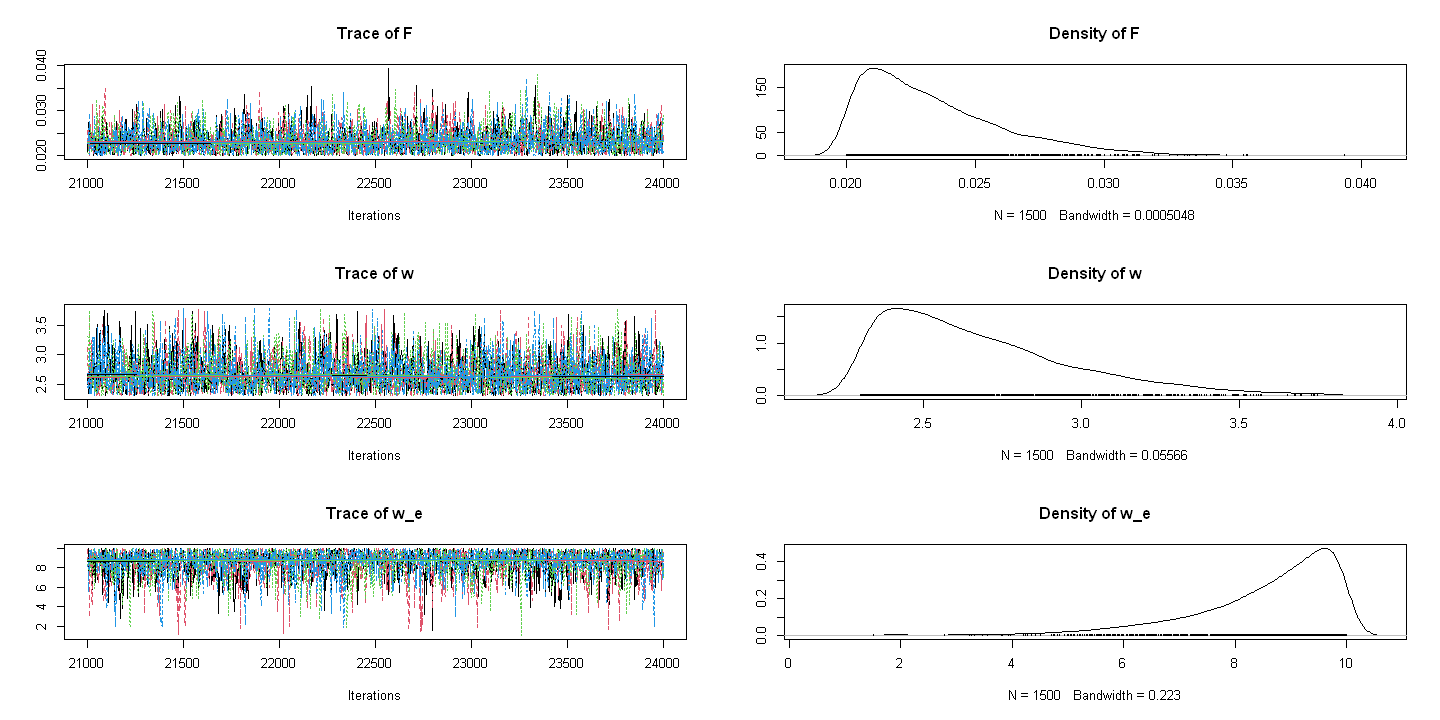

In [76]:
plot(jags_samples_AmCsCo)
summary(jags_samples_AmCsCo)


Iterations = 31004:41000
Thinning interval = 4 
Number of chains = 4 
Sample size per chain = 2500 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean       SD  Naive SE Time-series SE
F   0.06169 0.009632 9.632e-05      0.0002651
w   2.99912 0.432129 4.321e-03      0.0117414
w_e 7.93428 1.982707 1.983e-02      0.0239240

2. Quantiles for each variable:

       2.5%     25%     50%     75%   97.5%
F   0.04645 0.05373 0.06086 0.06909 0.08071
w   2.33100 2.62389 2.97320 3.36753 3.75354
w_e 2.43202 7.08747 8.59200 9.42465 9.95031


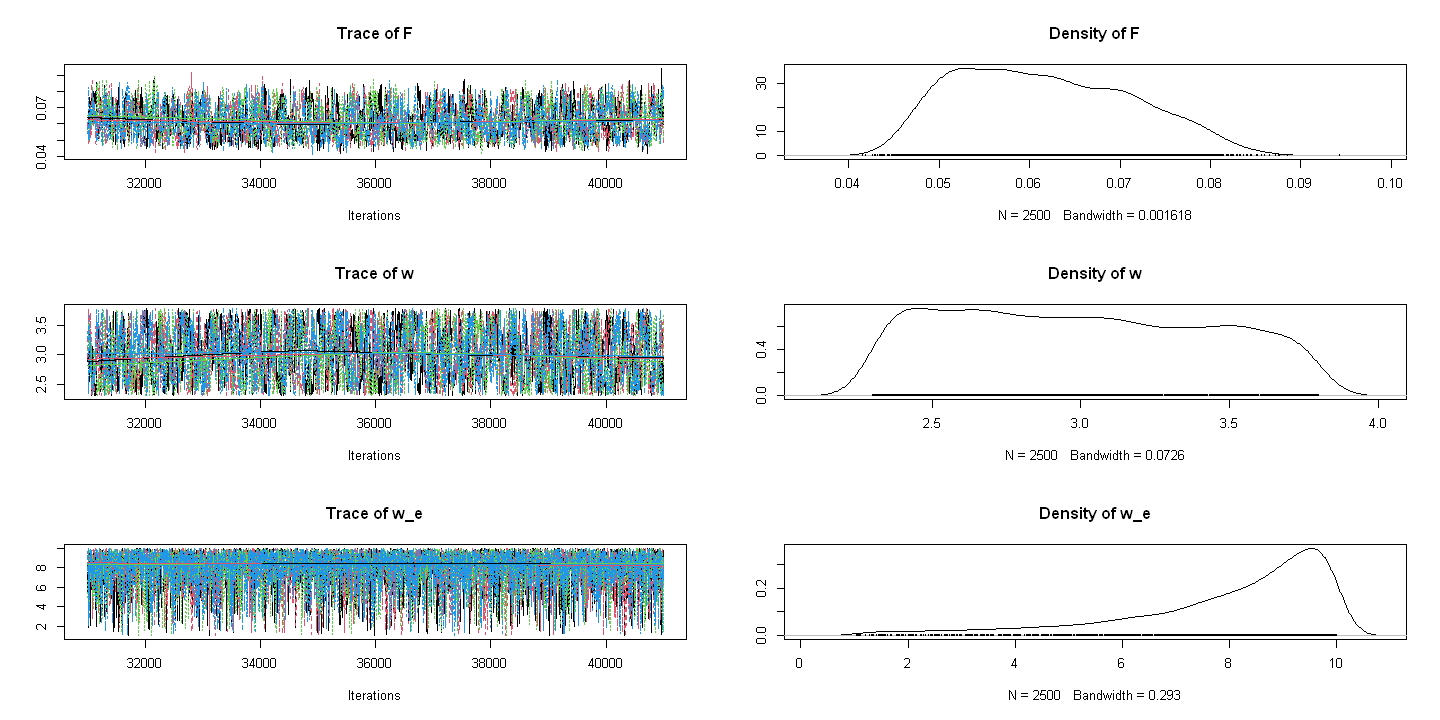

In [77]:
plot(jags_samples_Th)
summary(jags_samples_Th)

In [78]:
# Check the convergence of the chain
gelman.diag(jags_samples_AmCsCo)
gelman.diag(jags_samples_Th)


Potential scale reduction factors:

    Point est. Upper C.I.
F            1       1.00
w            1       1.00
w_e          1       1.01

Multivariate psrf

1

Potential scale reduction factors:

    Point est. Upper C.I.
F            1       1.01
w            1       1.00
w_e          1       1.00

Multivariate psrf

1

The Gelman-Rubin diagnostics (Potential Scale Reduction Factor, PSRF) indicate that the chains have likely converged. Specifically:

A Point Estimate of 1 for all parameters indicates good convergence.  
An Upper C.I. (Upper Confidence Interval) close to 1 (1.01) is another sign of good convergence.

In [79]:
# Check the autocorrelation
autocorr.diag(jags_samples_AmCsCo)
autocorr.diag(jags_samples_Th)

,F,w,w_e
Lag 0,1.000000000,1.000000000,1.00000000
Lag 2,0.321593279,0.305727802,0.40588945
Lag 10,0.011400819,0.016203020,0.01309172
Lag 20,-0.002170614,0.007961412,-0.00531249
Lag 100,0.009741942,-0.004497353,-0.01453769


,F,w,w_e
Lag 0,1.00000000,1.00000000,1.00000000
Lag 4,0.74890601,0.76363265,0.19184469
Lag 20,0.25469685,0.26213360,0.01088122
Lag 40,0.07072107,0.07536208,0.00823184
Lag 200,-0.01747986,-0.03150700,-0.00164745


**Lag 0**: Autocorrelation is always 1 at lag 0, representing the correlation of the sample with itself.  
**Low Lags (Lag 2, 4, 10)**: These values show the correlation between samples that are close to each other. Here we still have from strong to low correlation.    
**Medium to High Lags (Lag 20, 40, 100, 200)**: As the lag increases, the autocorrelation decreases, approaching zero, which is desirable. This indicates that the samples become less correlated and more independent as the lag increases.

### 3.d Result Analysis  
Extract the results and analyze the parameters:

Estimated parameters (JAGS):
F: 0.02337587 
w: 2.676974 
w_e: 8.515263 


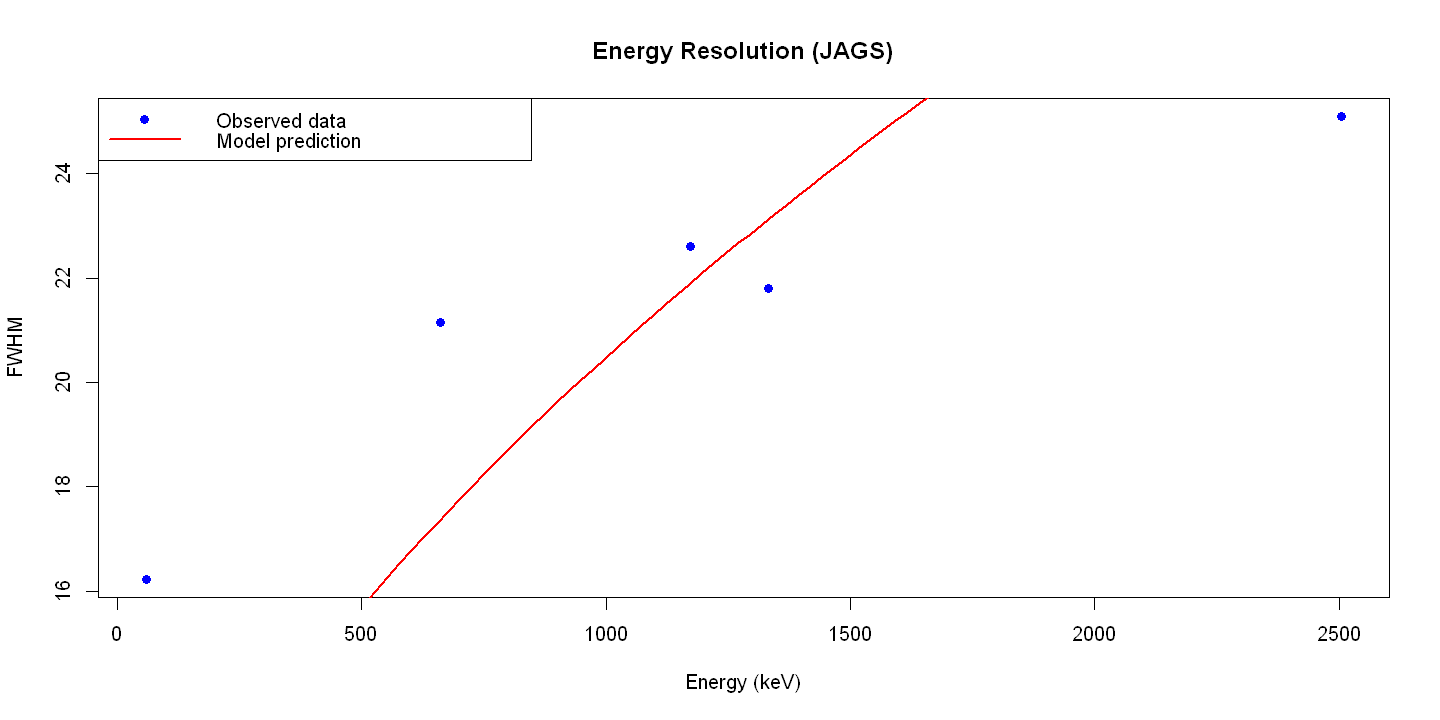

In [80]:
# Extract results from JAGS
results_jags <- as.matrix(jags_samples_AmCsCo)

# Get posterior estimates for parameters
F_est_jags <- mean(results_jags[, "F"])
w_est_jags <- mean(results_jags[, "w"])
w_e_est_jags <- mean(results_jags[, "w_e"])

# Print estimated parameters
cat("Estimated parameters (JAGS):\n")
cat("F:", F_est_jags, "\n")
cat("w:", w_est_jags, "\n")
cat("w_e:", w_e_est_jags, "\n")

# Plot the energy resolution function
energy_range_jags <- seq(min(energies_AmCsCo), max(energies_AmCsCo), length.out = 100)
w_d_jags <- 2 * sqrt(2 * log(2) * F_est_jags * energy_range_jags * w_est_jags)
predicted_fwhm_jags <- sqrt(w_d_jags^2 + w_e_est_jags^2)
plot(energies_AmCsCo, fwhm_values_AmCsCo, pch = 19, col = "blue", xlab = "Energy (keV)", ylab = "FWHM", main = "Energy Resolution (JAGS)")
lines(energy_range_jags, predicted_fwhm_jags, col = "red", lwd = 2)
legend("topleft", legend = c("Observed data", "Model prediction"),
       col = c("blue", "red"), pch = c(19, NA), lty = c(NA, 1), lwd = c(NA, 2))

Estimated parameters (JAGS):
F: 0.06169417 
w: 2.999116 
w_e: 7.93428 


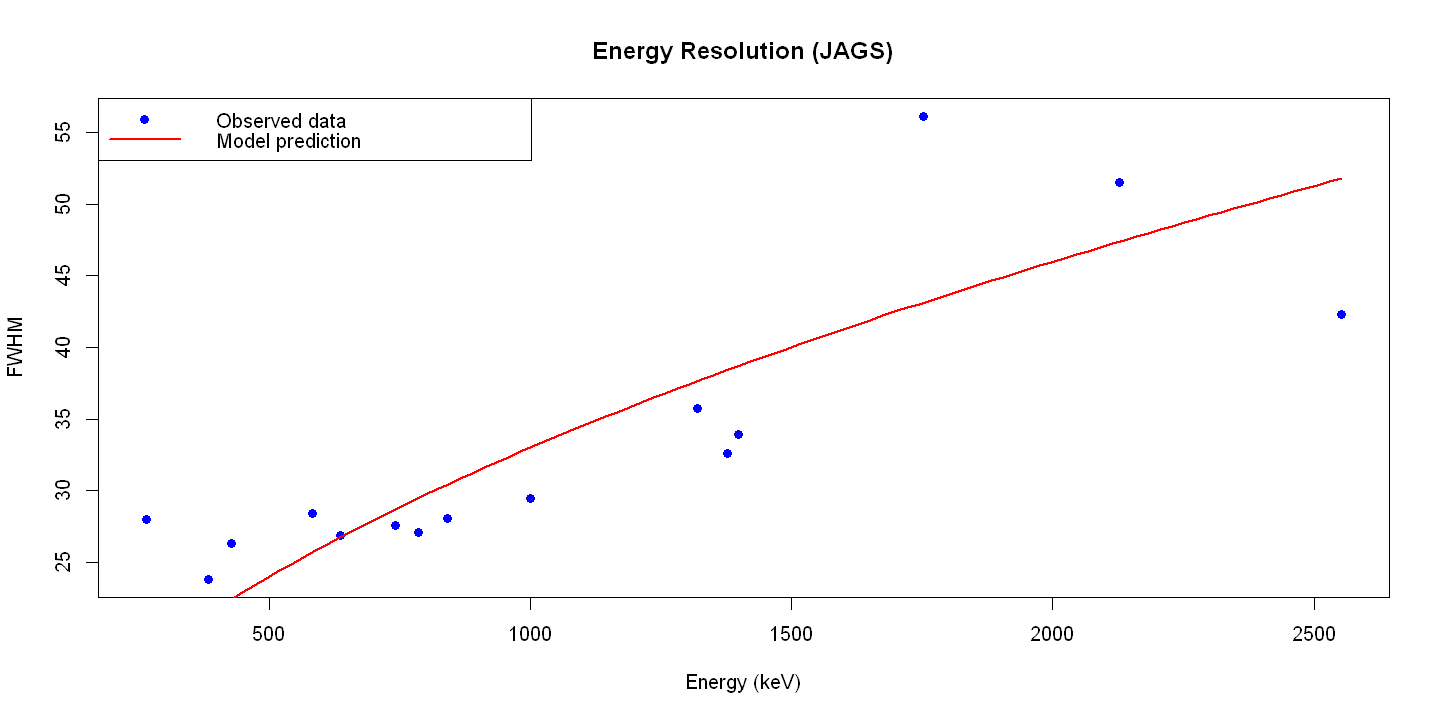

In [81]:
# Extract results from JAGS
results_jags <- as.matrix(jags_samples_Th)

# Get posterior estimates for parameters
F_est_jags <- mean(results_jags[, "F"])
w_est_jags <- mean(results_jags[, "w"])
w_e_est_jags <- mean(results_jags[, "w_e"])

# Print estimated parameters
cat("Estimated parameters (JAGS):\n")
cat("F:", F_est_jags, "\n")
cat("w:", w_est_jags, "\n")
cat("w_e:", w_e_est_jags, "\n")

# Plot the energy resolution function
energy_range_jags <- seq(min(energies_Th), max(energies_Th), length.out = 100)
w_d_jags <- 2 * sqrt(2 * log(2) * F_est_jags * energy_range_jags * w_est_jags)
predicted_fwhm_jags <- sqrt(w_d_jags^2 + w_e_est_jags^2)
plot(energies_Th, fwhm_values_Th, pch = 19, col = "blue", xlab = "Energy (keV)", ylab = "FWHM", main = "Energy Resolution (JAGS)")
lines(energy_range_jags, predicted_fwhm_jags, col = "red", lwd = 2)
legend("topleft", legend = c("Observed data", "Model prediction"),
       col = c("blue", "red"), pch = c(19, NA), lty = c(NA, 1), lwd = c(NA, 2))

In this graph, the observed data (blue dots) and the predicted model (red line) for energy resolution are represented.  
On the x-axis, the energy in keV of the detected gamma peaks is indicated, while the y-axis shows the FWHM of these peaks.

The blue points show the experimental measurements of the energy resolution (FWHM) at various energies. The red line shows the energy resolution predicted by the JAGS model based on the parameters estimated from the data.  
This line closely follows the distribution of the blue points (more so for Th than for AmCsCo), indicating that the predicted model is in good agreement with the observed data, suggesting that the estimated parameters ($F$, $w$, $w_e$) are a good representation of the detector's characteristics.  
As for the AmCsCo graph, the red line follows the distribution of the blue points but not perfectly. This could indicate that the model is not capturing all aspects of the detector's energy resolution or that the observed data used in the model is too sparse to achieve an optimal result.

## Step 4: Energy resolution for NaI detector

### 4.a Data inspectionad FWHM derivation

In [82]:
# Extract data points around each peak
peak_data_list_co60  <- extract_peak_data(gr11_co60, peaks_co60, window_size = 110)
peak_data_list_cs137  <- extract_peak_data(gr11_cs137, peaks_cs137, window_size = 100)
peak_data_list_na22  <- extract_peak_data(gr11_na22, peaks_na22, window_size = 100)

In [83]:
# Fit the model for each peak
fits_co60 <- lapply(peak_data_list_co60, fit_gaussian_nls)
fits_cs137 <- lapply(peak_data_list_cs137, fit_gaussian_nls)
fits_na22 <- lapply(peak_data_list_na22, fit_gaussian_nls)

# Calculate FWHM for each peak
fwhm_values_co60 <- sapply(fits_co60, calculate_fwhm)
fwhm_values_cs137 <- sapply(fits_cs137, calculate_fwhm)
fwhm_values_na22 <- sapply(fits_na22, calculate_fwhm)

fwhm_values_NaI <- c(fwhm_values_cs137, fwhm_values_co60, fwhm_values_na22)


# Extract the names (keys)
channels <- names(fwhm_values_NaI)

# Remove ".sigma" from the names to sort correctly
channels_numeric <- as.numeric(gsub(".sigma", "", channels))

# Sort the keys and get the sorting index
order_indices <- order(channels_numeric)

# Sort the keys
sorted_channels <- channels[order_indices]

# Reorder the FWHM values according to the order of the keys
fwhm_values_NaI <- fwhm_values_NaI[order_indices]

# Assign the sorted names to the sorted values
names(fwhm_values_NaI) <- sorted_channels

# Print the FWHM values sorted by channel
print(fwhm_values_NaI)


1361.sigma 1773.sigma 3053.sigma 3311.sigma 3455.sigma 
  456.9448   411.5100   566.8344   432.4574   500.0983 


In [84]:
peaks <- c(peaks_cs137, peaks_co60, peaks_na22)

peaks_NaI <- sort(peaks)

### 4.b Calibration of the detector


Call:
lm(formula = Energy_NaI ~ Channel_NaI, data = calibration_data_NaI)

Residuals:
       1        2        3        4        5 
 5.21677 -6.56721  0.33281 -0.08094  1.09857 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -30.823965   6.969783  -4.423   0.0215 *  
Channel_NaI   0.394274   0.002555 154.334    6e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4.888 on 3 degrees of freedom
Multiple R-squared:  0.9999,	Adjusted R-squared:  0.9998 
F-statistic: 2.382e+04 on 1 and 3 DF,  p-value: 5.998e-07


`geom_smooth()` using formula = 'y ~ x'


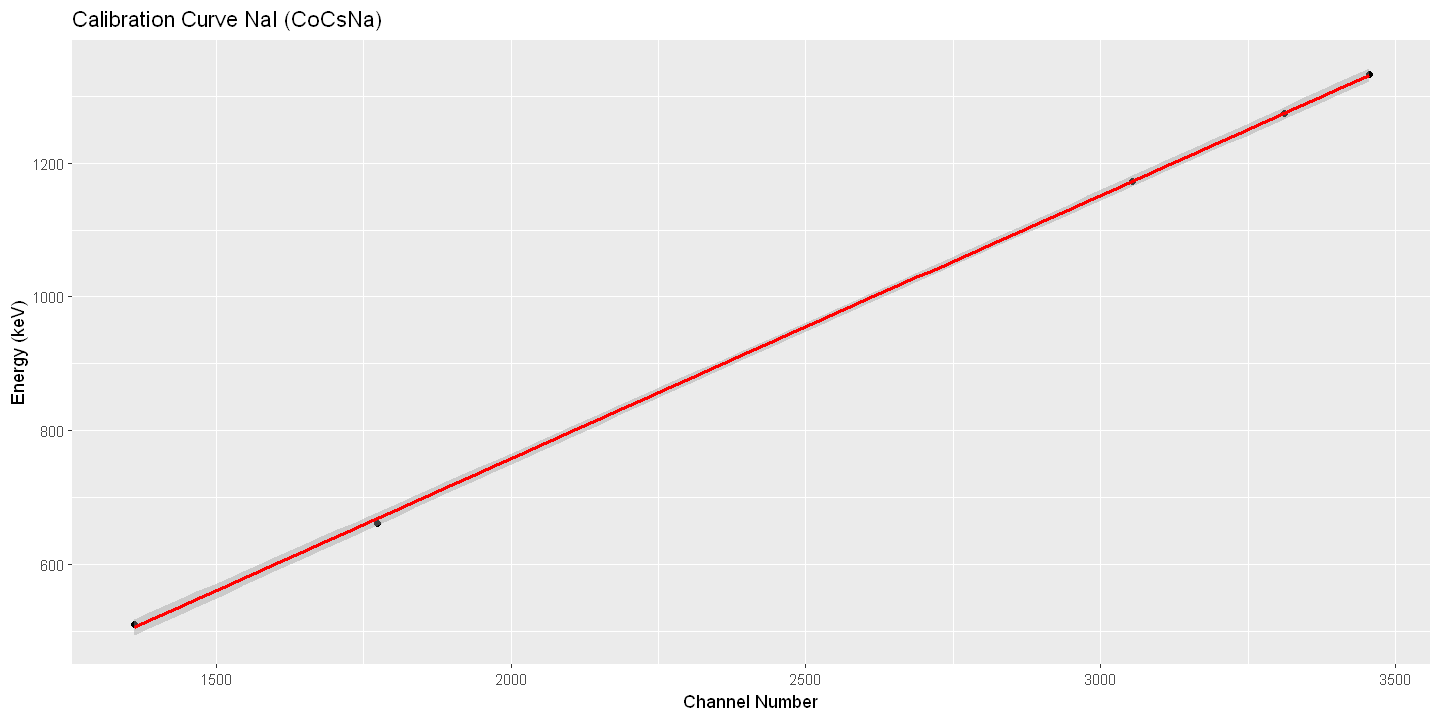

In [85]:
# Identify Known gamma energies
NaI_energies <- c(1173.228, 1332.492, 661.657, 511, 1274.537)
NaI_energies <- sort(NaI_energies)
#cat('Nai energies: \n', NaI_energies)

# Create a data frame with the positions and corresponding energies
calibration_data_NaI <- data.frame(
    Channel_NaI = peaks_NaI,
    Energy_NaI = NaI_energies
)

# Fit the linear model 
calibration_model_NaI <- lm(Energy_NaI ~ Channel_NaI, data= calibration_data_NaI)
summary(calibration_model_NaI)

# Plot the calibration data and the fitted model
ggplot(calibration_data_NaI, aes(x = Channel_NaI, y = Energy_NaI)) +
  geom_point() +
  geom_smooth(method = "lm", col = "red") +
  ggtitle("Calibration Curve NaI (CoCsNa)") +
  xlab("Channel Number") +
  ylab("Energy (keV)")

  Channel_NaI Energy_NaI
1        1361   505.7832
2        1773   668.2242
3        3053  1172.8952
4        3311  1274.6179
5        3455  1331.3934


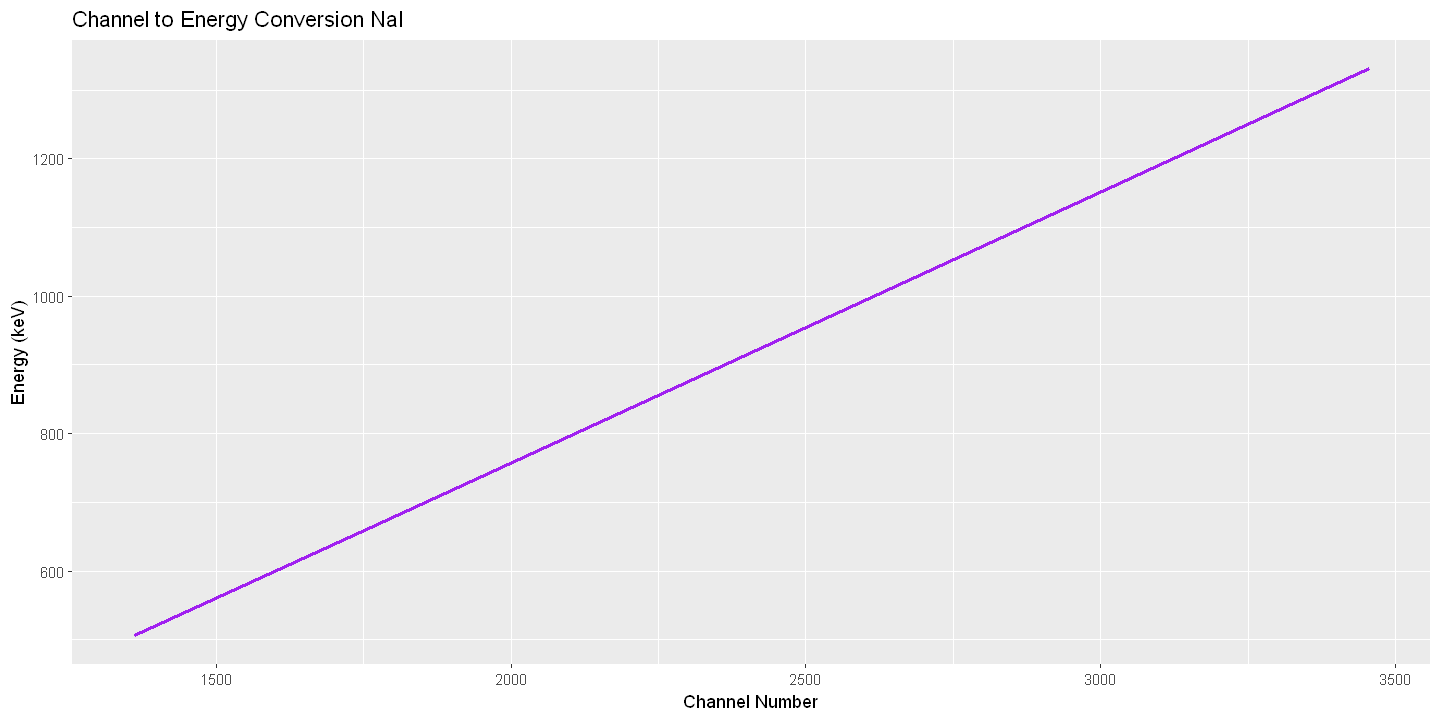

In [86]:
# Apply calibration to the channels
energies_NaI <- channel_to_energy(calibration_data_NaI$Channel_NaI, calibration_model_NaI, "Channel_NaI")

# Create data frames with channels and corresponding energies
calibrated_data_NaI<- data.frame(
    Channel_NaI = calibration_data_NaI$Channel_NaI,
    Energy_NaI = energies_NaI)

print(calibrated_data_NaI )

# Plot the calibration results for AmCsCo
ggplot(calibrated_data_NaI, aes(x = Channel_NaI, y = Energy_NaI)) +
  geom_line(col='purple', lwd=1.1) +
  ggtitle("Channel to Energy Conversion NaI") +
  xlab("Channel Number") +
  ylab("Energy (keV)")

### 4.c Study energy resolution using MCMC

In [87]:
# Define JAGS model code
# F ~ 0.1
jags_model_code_NaI <- "
# w ~ 5.9 eV
model {
  for (i in 1:N) {
    w_d[i] <- 2 * sqrt(2 * log(2) * F * E_gamma[i] * w)
    FWHM[i] ~ dnorm(sqrt(w_d[i]^2 + w_e^2), prec)
  }
  
  F ~ dunif(0, 0.5)   # Prior uniforme per F
  w ~ dunif(4.5, 7)  # Prior uniforme per w
  w_e ~ dunif(400, 500)  # Prior uniforme per w_e
}
"

In [88]:
# Prepare data for JAGS
jags_data_NaI <- list(
  N = length(energies_NaI),
  E_gamma = energies_NaI,
  FWHM = fwhm_values_NaI,
  prec = 0.1  # Precisione per la distribuzione normale
)

In [89]:
# Compile and run the JAGS models
jags_model_NaI <- jags.model(textConnection(jags_model_code_NaI), data = jags_data_NaI, n.chains = 4)
update(jags_model_NaI, 20000)  # Burn-in di 20k iterazioni
jags_samples_NaI <- coda.samples(jags_model_NaI, variable.names = c("F", "w", "w_e"), n.iter = 3000, thin = 2)


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 5
   Unobserved stochastic nodes: 3
   Total graph size: 54

Initializing model




Iterations = 21002:24000
Thinning interval = 2 
Number of chains = 4 
Sample size per chain = 1500 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean       SD  Naive SE Time-series SE
F     0.492 0.007984 0.0001031      0.0001809
w     6.887 0.115228 0.0014876      0.0026719
w_e 453.267 1.566509 0.0202235      0.0234509

2. Quantiles for each variable:

        2.5%     25%      50%      75%    97.5%
F     0.4706   0.489   0.4945   0.4977   0.4998
w     6.5872   6.844   6.9232   6.9680   6.9973
w_e 450.2913 452.194 453.2571 454.3248 456.3628


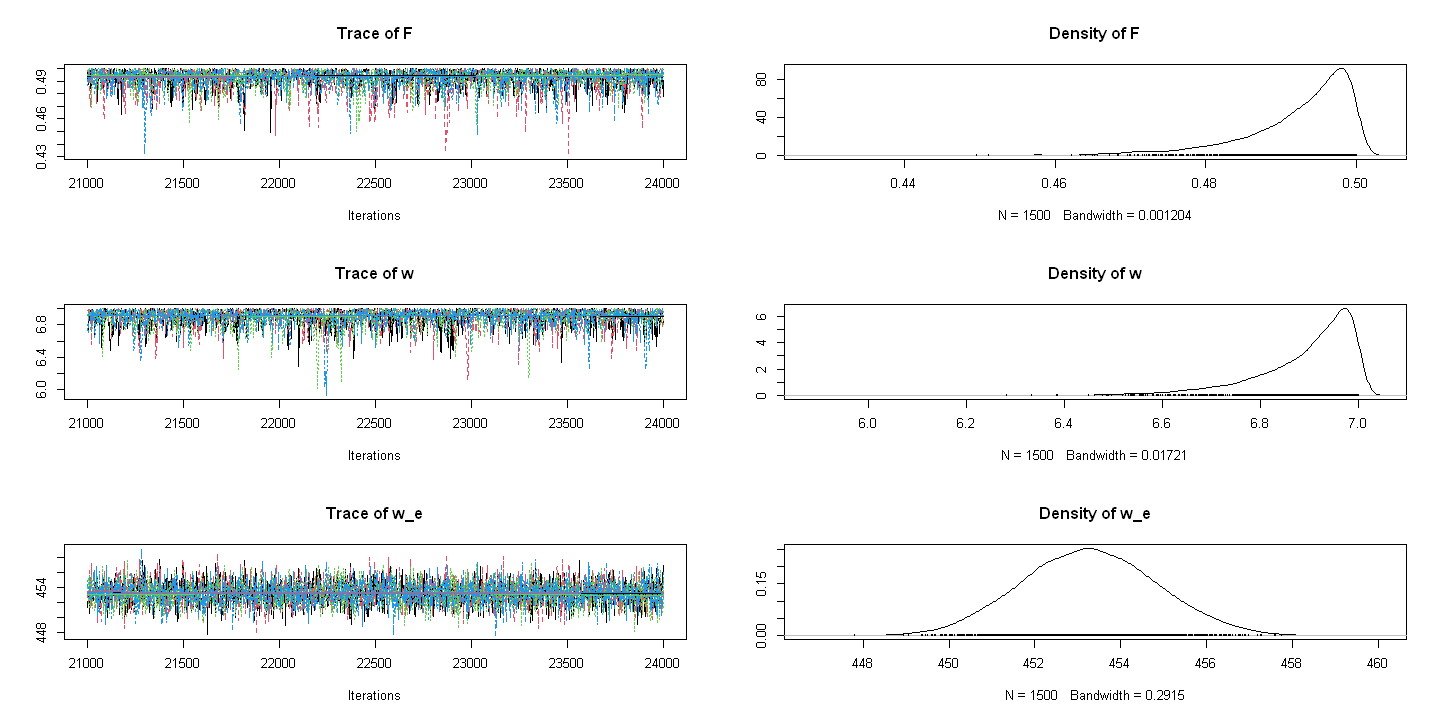

In [90]:
plot(jags_samples_NaI)
summary(jags_samples_NaI)

In [91]:
# Check the convergence of the chain
gelman.diag(jags_samples_NaI)

Potential scale reduction factors:

    Point est. Upper C.I.
F         1.02       1.03
w         1.00       1.00
w_e       1.00       1.01

Multivariate psrf

1.01

In [92]:
# Check the autocorrelation
autocorr.diag(jags_samples_NaI)

,F,w,w_e
Lag 0,1.00000000,1.00000000,1.000000000
Lag 2,0.44498802,0.51042373,0.120965732
Lag 10,0.04437751,0.03113182,0.002646215
Lag 20,0.02100009,0.01355378,0.007384038
Lag 100,0.00464959,0.01821705,0.002978807


### 4.d Result Analysis

Estimated parameters (JAGS):
F: 0.4920186 
w: 6.887412 
w_e: 453.2671 


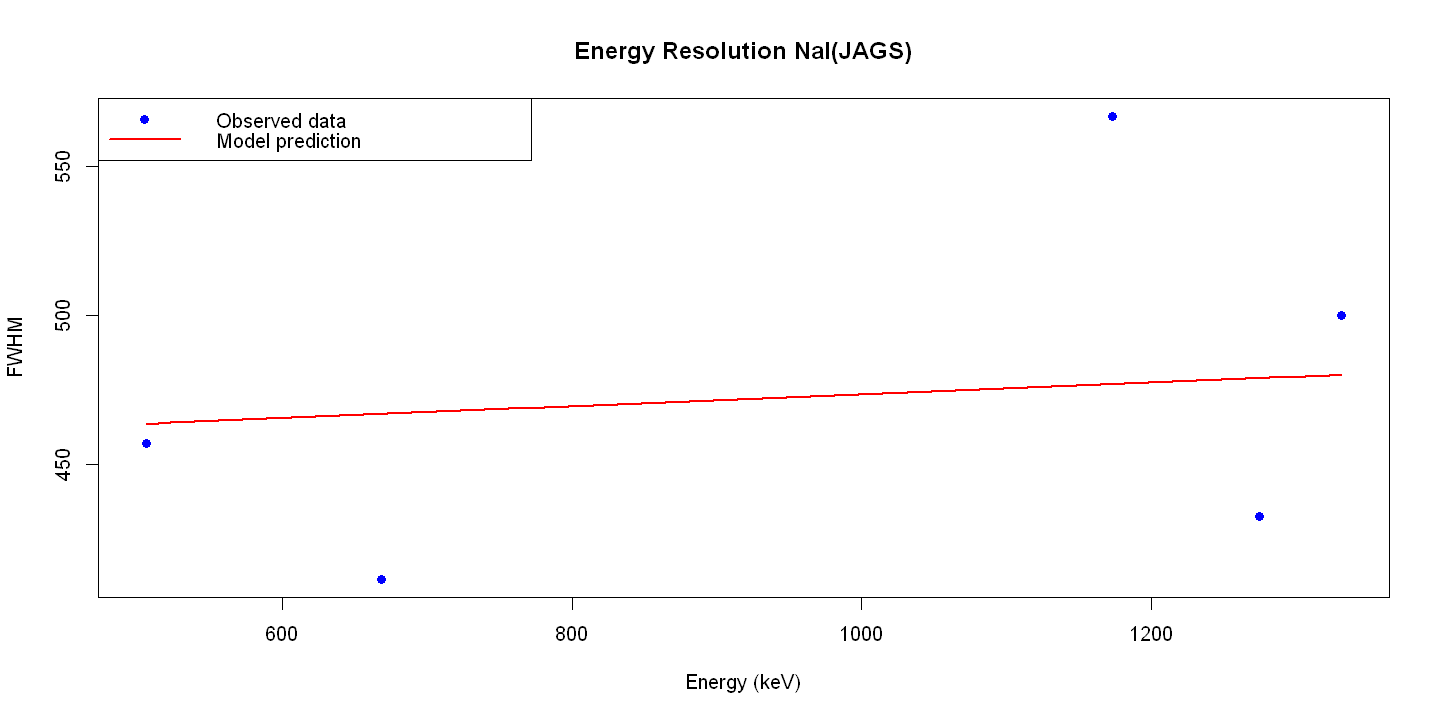

In [93]:
# Extract results from JAGS
results_jags <- as.matrix(jags_samples_NaI)

# Get posterior estimates for parameters
F_est_jags <- mean(results_jags[, "F"])
w_est_jags <- mean(results_jags[, "w"])
w_e_est_jags <- mean(results_jags[, "w_e"])

# Print estimated parameters
cat("Estimated parameters (JAGS):\n")
cat("F:", F_est_jags, "\n")
cat("w:", w_est_jags, "\n")
cat("w_e:", w_e_est_jags, "\n")

# Plot the energy resolution function
energy_range_jags <- seq(min(energies_NaI), max(energies_NaI), length.out = 100)
w_d_jags <- 2 * sqrt(2 * log(2) * F_est_jags * energy_range_jags * w_est_jags)
predicted_fwhm_jags <- sqrt(w_d_jags^2 + w_e_est_jags^2)
plot(energies_NaI, fwhm_values_NaI, pch = 19, col = "blue", xlab = "Energy (keV)", ylab = "FWHM", main = "Energy Resolution NaI(JAGS)")
lines(energy_range_jags, predicted_fwhm_jags, col = "red", lwd = 2)
legend("topleft", legend = c("Observed data", "Model prediction"),
       col = c("blue", "red"), pch = c(19, NA), lty = c(NA, 1), lwd = c(NA, 2))